## **Fine Tuning Bert for Keyword identification**

In [ ]:
import pandas as pd
from transformers import BertTokenizerFast, BertForTokenClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
import torch
from google.colab import files
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt

# Upload dataset
uploaded = files.upload()

# Load dataset
file_path = list(uploaded.keys())[0]
df = pd.read_excel(file_path)

# Inspect the DataFrame structure
print(df.head())

# Ensure the column names match your Excel file
text_column = df.columns[0]  # Change this if the text column has a different name
keywords_column = df.columns[1]  # Change this if the keywords column has a different name

# Tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')  #we load the bert tokenizer to get the embeddings(vector size:768) of each word/token

# Data preparation: Convert paragraphs and keywords to token labels
class KeywordDataset(Dataset):
    def __init__(self, texts, keywords, tokenizer, max_len):
        self.texts = texts
        self.keywords = keywords
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        keywords = self.keywords[idx]   #Retrieves the text and corresponding keywords for the given index

        encoding = self.tokenizer(text,
                                  padding='max_length',
                                  truncation=True,
                                  max_length=self.max_len,    #Tokenizes the text using the BERT tokenizer, applying padding and truncation to ensure the length does not exceed max_len.
                                  return_tensors="pt")        # The tokenized output is converted into PyTorch tensors.

        labels = self._create_labels(text, keywords, encoding)  # the labels are created for each paragraph and returned

        item = {key: val.squeeze() for key, val in encoding.items()}  # encoding is 3D array then its squeezed to get a 2D array which is item

        # encoding = {
        # "input_ids": torch.tensor([[101, 2023, 4248, 2829, 4419, 102]]),  # Shape: (1, 6)
        # "attention_mask": torch.tensor([[1, 1, 1, 1, 1, 1]]),            # Shape: (1, 6)
        # "token_type_ids": torch.tensor([[0, 0, 0, 0, 0, 0]])              # Shape: (1, 6)
        # }

        # item = {
        # "input_ids": torch.tensor([101, 2023, 4248, 2829, 4419, 102]),  # Shape: (6,)
        # "attention_mask": torch.tensor([1, 1, 1, 1, 1, 1]),            # Shape: (6,)
        # "token_type_ids": torch.tensor([0, 0, 0, 0, 0, 0])              # Shape: (6,)
        # }

        item['labels'] = torch.tensor(labels, dtype=torch.long)

        return item

        # item = {
        # "input_ids": torch.tensor([101, 2023, 4248, 2829, 4419, 102]),  # Example input IDs
        # "attention_mask": torch.tensor([1, 1, 1, 1, 1, 1]),            # Example attention mask
        # "token_type_ids": torch.tensor([0, 0, 0, 0, 0, 0]),            # Example token type IDs
        # "labels": torch.tensor([-100, 0, 0, 1, 0, 1], dtype=torch.long) # Labels tensor
        # }


    def _create_labels(self, text, keywords, encoding):   # eg: ["[CLS]", "the", "quick", "brown", "fox", "jumps", "over", "the", "lazy", "dog", ".", "[SEP]"] | the keywords are: fox and dog
        word_ids = encoding.word_ids()      #assigns word_ids [None, 0, 1, 2, 3, 4, 5, 6, 7, 8, None, None]  , word_ids are generated by mapping each token in the input_ids of the encoding
        labels = [-100 if i is None else 0 for i in word_ids]   #-100 is assigned for None values (special tokens) and punctuations, 0 for other words

        for keyword in keywords:
            keyword_tokens = self.tokenizer.tokenize(keyword)    #tokenized word, eg: ["memory"] or ["play","##ing"]
            keyword_ids = self.tokenizer.convert_tokens_to_ids(keyword_tokens) #id assigned to the keywords
            for i, word_id in enumerate(word_ids):
                if word_id is None:
                    continue
                token_id = encoding["input_ids"][0][i].item()  # each word's computed id is accessed and the item() converts the tensor into int
                if token_id in keyword_ids:
                    labels[i] = 1  #keywords are assigned label as 1

        return labels     # [-100, 0, 0, 0, 1, 0, 0, 0, 1, 0, -100, -100]


# Split data into training and testing sets
texts = df[text_column].tolist()  # each paragraphs are entered into a list
keywords = df[keywords_column].apply(lambda x: x.split(',')).tolist()   # each keyword are separated by a , so its entering all the keywords into a list
train_texts, test_texts, train_keywords, test_keywords = train_test_split(texts, keywords, test_size=0.2, random_state=42)  #split in 80:20 ratio as train and test datasets

# Preprocess datasets
train_dataset = KeywordDataset(train_texts, train_keywords, tokenizer, max_len=128)
test_dataset = KeywordDataset(test_texts, test_keywords, tokenizer, max_len=128)

# Load model with dropout
model = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=2)   # 1 if it's a beginnig of a name/entity , 0 if its outside entity
model.config.hidden_dropout_prob = 0.3  # Set dropout to 30%, 30% of the units in the hidden layers will be randomly dropped out during training. This helps prevent overfitting by introducing regularization.

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.005,   #prevent overfitting by adding a penalty for adjusting large weights
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy='epoch',    #model will be evaluated at the end of each epoch.
    save_strategy='epoch',
    save_total_limit=2,   #keep only the last 2 checkpoints of saved model
    load_best_model_at_end=True,
    learning_rate= 1e-5,  # Change learning rate to 1e-5, how much to change the model's weights with respect to the loss gradient
)

# Compute metrics function
def compute_metrics(pred):
    labels = pred.label_ids.flatten()   #convert the label_ids list into a 1D array
    preds = pred.predictions.argmax(-1).flatten()

    #labels = np.array([-100, 1, 0, 0, 2, 2, -100, -100])
    # preds = np.array([1, 0, 0, 0, 1, 1, 0, 0])  # Shape: (8,)

    mask = labels != -100   #mask = np.array([False, True, True, True, True, True, False, False])
    labels = labels[mask]   #labels = np.array([1, 0, 0, 2, 2])  keeping only the elements where mask is True
    preds = preds[mask]     #preds = np.array([ 0, 0, 0, 1, 1])

    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')   #scikit learn func
    #precision: The ratio of true positive predictions to the total predicted positives
    # recall: The ratio of true positive predictions to the total actual positives
    # f1: harmonic mean of both
    accuracy = (labels == preds).mean()
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

# Save the model
model_save_path = "./fine_tuned_keyword_extraction_model1"
model.save_pretrained(model_save_path)
trainer.save_model(model_save_path)



Saving OS_Dataset3.xlsx to OS_Dataset3.xlsx
                                           Paragraph  \
0  Operating systems (OS) are crucial software th...   
1  They provide a stable and consistent environme...   
2  Key functions include process management, memo...   
3  Operating systems also handle system security ...   
4  Key functions include process management, memo...   

                                            Keywords  
0  operating systems, software, computer hardware...  
1  operating systems, software, computer hardware...  
2  operating systems, software, computer hardware...  
3  operating systems, software, computer hardware...  
4  operating systems, software, computer hardware...  


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.234000,0.204686,0.907815,0.752894,0.768913,0.760819
2,0.133900,0.110209,0.953964,0.846798,0.926123,0.884686
3,0.088300,0.087191,0.965572,0.863815,0.972813,0.915080


Saving OS_Dataset3.xlsx to OS_Dataset3.xlsx
                                           Paragraph  \
0  Operating systems (OS) are crucial software th...   
1  They provide a stable and consistent environme...   
2  Key functions include process management, memo...   
3  Operating systems also handle system security ...   
4  Key functions include process management, memo...   

                                            Keywords  
0  operating systems, software, computer hardware...  
1  operating systems, software, computer hardware...  
2  operating systems, software, computer hardware...  
3  operating systems, software, computer hardware...  
4  operating systems, software, computer hardware...  


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: veerviswajit2004 (veerviswajit2004-vit-campus) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.233100,0.203439,0.907477,0.754232,0.763593,0.758884
2,0.136300,0.109308,0.953964,0.855048,0.913416,0.883269
3,0.085600,0.088100,0.964107,0.857775,0.973109,0.911809


Validation AUROC: 0.9936


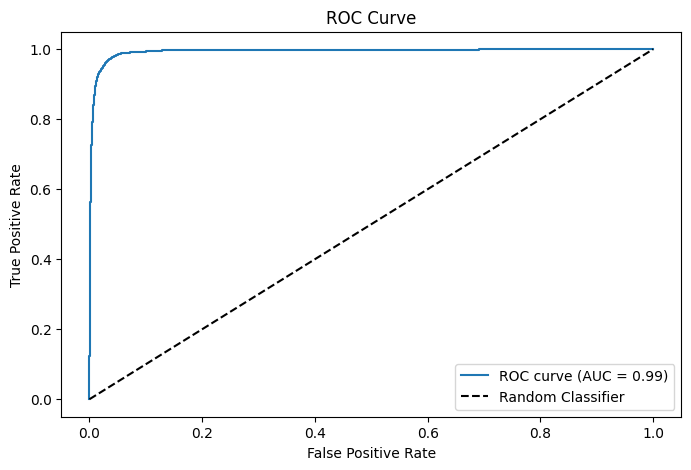

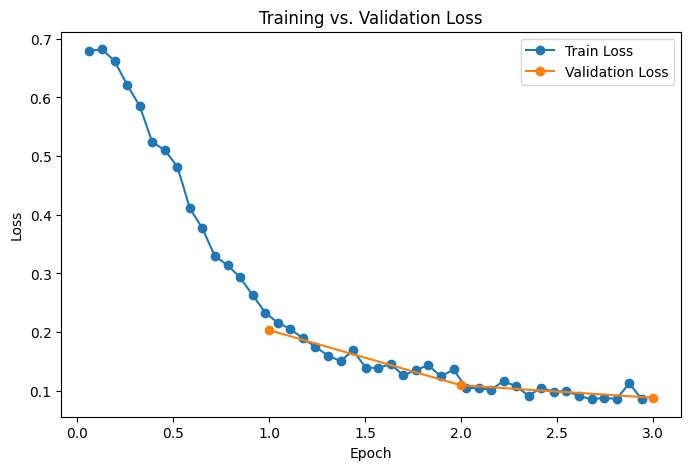

In [ ]:
import pandas as pd
from transformers import BertTokenizerFast, BertForTokenClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
import torch
from google.colab import files
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import scipy.special

# -------------------------------
# Upload dataset
# -------------------------------
uploaded = files.upload()

# Load dataset
file_path = list(uploaded.keys())[0]
df = pd.read_excel(file_path)

# Inspect the DataFrame structure
print(df.head())

# Ensure the column names match your Excel file
text_column = df.columns[0]    # Change if necessary
keywords_column = df.columns[1]  # Change if necessary

# -------------------------------
# Tokenizer and Dataset Preparation
# -------------------------------
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

class KeywordDataset(Dataset):
    def __init__(self, texts, keywords, tokenizer, max_len):
        self.texts = texts
        self.keywords = keywords
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        keywords = self.keywords[idx]   # Retrieve text and corresponding keywords

        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        labels = self._create_labels(text, keywords, encoding)
        # Squeeze the tensors from shape [1, seq_len] to [seq_len]
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.long)
        return item

    def _create_labels(self, text, keywords, encoding):
        # Get word_ids mapping tokens to words (None for special tokens)
        word_ids = encoding.word_ids()
        # Set -100 for special tokens and 0 for others initially
        labels = [-100 if i is None else 0 for i in word_ids]

        for keyword in keywords:
            keyword_tokens = self.tokenizer.tokenize(keyword)
            keyword_ids = self.tokenizer.convert_tokens_to_ids(keyword_tokens)
            for i, word_id in enumerate(word_ids):
                if word_id is None:
                    continue
                token_id = encoding["input_ids"][0][i].item()
                if token_id in keyword_ids:
                    labels[i] = 1  # Mark keyword tokens with label 1
        return labels

# Split data into training and testing sets (80/20 split)
texts = df[text_column].tolist()
keywords = df[keywords_column].apply(lambda x: x.split(',')).tolist()
train_texts, test_texts, train_keywords, test_keywords = train_test_split(texts, keywords, test_size=0.2, random_state=42)

train_dataset = KeywordDataset(train_texts, train_keywords, tokenizer, max_len=128)
test_dataset = KeywordDataset(test_texts, test_keywords, tokenizer, max_len=128)

# -------------------------------
# Load pre-trained model (with dropout) for token classification
# -------------------------------
model = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.config.hidden_dropout_prob = 0.3  # 30% dropout

# -------------------------------
# Training Arguments
# -------------------------------
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.005,  # Regularization to prevent overfitting
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy='epoch',  # Evaluate at the end of each epoch
    save_strategy='epoch',
    save_total_limit=2,
    load_best_model_at_end=True,
    learning_rate=1e-5,
)

# -------------------------------
# Compute Metrics Function
# -------------------------------
def compute_metrics(pred):
    labels = pred.label_ids.flatten()
    preds = pred.predictions.argmax(-1).flatten()

    # Only evaluate on tokens with labels (ignore -100 values)
    mask = labels != -100
    labels = labels[mask]
    preds = preds[mask]

    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    accuracy = (labels == preds).mean()
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}

# -------------------------------
# Initialize Trainer
# -------------------------------
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

# -------------------------------
# Evaluate AUROC on the test set
# -------------------------------
pred_output = trainer.predict(test_dataset)
logits = pred_output.predictions  # Shape: (num_examples, seq_len, num_labels)
labels = pred_output.label_ids     # Shape: (num_examples, seq_len)

# Flatten predictions and labels, ignoring tokens with label -100
mask = labels != -100
flat_labels = labels[mask]
flat_logits = logits[mask]

# Compute softmax probabilities for class 1
probs = scipy.special.softmax(flat_logits, axis=-1)[:, 1]
auc = roc_auc_score(flat_labels, probs)
fpr, tpr, _ = roc_curve(flat_labels, probs)
print(f"Validation AUROC: {auc:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

# -------------------------------
# Plot Training vs. Validation Loss Curves
# -------------------------------
log_history = trainer.state.log_history

# Extract evaluation logs (one eval loss per epoch)
eval_logs = [entry for entry in log_history if 'eval_loss' in entry and 'epoch' in entry]
# Extract training loss logs (may have several per epoch)
train_logs = [entry for entry in log_history if 'loss' in entry and 'epoch' in entry]

# Average training losses per epoch
train_loss_dict = {}
for entry in train_logs:
    epoch = entry['epoch']
    train_loss_dict.setdefault(epoch, []).append(entry['loss'])
avg_train_losses = sorted((epoch, np.mean(losses)) for epoch, losses in train_loss_dict.items())
epochs_train, losses_train = zip(*avg_train_losses)

# For evaluation losses, assume one eval loss per epoch (sorted by epoch)
eval_logs_sorted = sorted(eval_logs, key=lambda x: x['epoch'])
epochs_eval = [entry['epoch'] for entry in eval_logs_sorted]
losses_eval = [entry['eval_loss'] for entry in eval_logs_sorted]

plt.figure(figsize=(8, 5))
plt.plot(epochs_train, losses_train, marker='o', label="Train Loss")
plt.plot(epochs_eval, losses_eval, marker='o', label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.show()

# -------------------------------
# Save the model
# -------------------------------
model_save_path = "./fine_tuned_keyword_extraction_model1"
model.save_pretrained(model_save_path)
trainer.save_model(model_save_path)


## **Fine Tuning Bert with LoRA for Keyword identification**

In [ ]:
# Install necessary libraries (run these in Colab if not already installed)
!pip install peft wandb scipy

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import scipy.special

from transformers import BertTokenizerFast, BertForTokenClassification, Trainer, TrainingArguments, TrainerCallback
from peft import LoraConfig, get_peft_model, TaskType

import wandb

# -------------------------------
# Initialize wandb
# -------------------------------
wandb.init(project="fine_tuning_with_lora", config={"run_name": "bert_token_classification_with_lora"})

# -------------------------------
# Upload and Load Dataset
# -------------------------------
from google.colab import files
uploaded = files.upload()

file_path = list(uploaded.keys())[0]
df = pd.read_excel(file_path)
print("Dataset preview:")
print(df.head())

# Define column names (adjust if necessary)
text_column = df.columns[0]
keywords_column = df.columns[1]

# -------------------------------
# Tokenizer and Dataset Preparation
# -------------------------------
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

class KeywordDataset(Dataset):
    def __init__(self, texts, keywords, tokenizer, max_len):
        self.texts = texts
        self.keywords = keywords
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        keywords = self.keywords[idx]
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        labels = self._create_labels(text, keywords, encoding)
        # Squeeze tensors from shape [1, seq_len] to [seq_len]
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.long)
        return item

    def _create_labels(self, text, keywords, encoding):
        word_ids = encoding.word_ids()
        # Set -100 for special tokens and 0 for others initially
        labels = [-100 if i is None else 0 for i in word_ids]
        for keyword in keywords:
            keyword_tokens = self.tokenizer.tokenize(keyword)
            keyword_ids = self.tokenizer.convert_tokens_to_ids(keyword_tokens)
            for i, word_id in enumerate(word_ids):
                if word_id is None:
                    continue
                token_id = encoding["input_ids"][0][i].item()
                if token_id in keyword_ids:
                    labels[i] = 1
        return labels

# Split the dataset (80% train, 20% test)
texts = df[text_column].tolist()
# Assumes keywords in Excel are comma-separated strings
keywords = df[keywords_column].apply(lambda x: x.split(',')).tolist()
train_texts, test_texts, train_keywords, test_keywords = train_test_split(
    texts, keywords, test_size=0.2, random_state=42)

train_dataset = KeywordDataset(train_texts, train_keywords, tokenizer, max_len=128)
test_dataset = KeywordDataset(test_texts, test_keywords, tokenizer, max_len=128)

# -------------------------------
# Load Pre-trained Model and Wrap with LoRA Layers
# -------------------------------
model = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.config.hidden_dropout_prob = 0.3  # Increase dropout to reduce overfitting

# Configure LoRA: target the "query" and "value" modules
lora_config = LoraConfig(
    task_type=TaskType.TOKEN_CLS,
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["query", "value"]
)

# Wrap the BERT model with LoRA layers
model = get_peft_model(model, lora_config)
print("LoRA Model:")
print(model)

# -------------------------------
# Training Arguments and Metrics Function
# -------------------------------
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.005,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    save_total_limit=2,
    load_best_model_at_end=True,
    learning_rate=1e-5,
    run_name="bert_token_classification_with_lora"  # distinct run name
)

def compute_metrics(pred):
    labels = pred.label_ids.flatten()
    preds = pred.predictions.argmax(-1).flatten()
    mask = labels != -100
    labels = labels[mask]
    preds = preds[mask]
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    accuracy = (labels == preds).mean()
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}

# -------------------------------
# Evaluation Function for AUROC
# -------------------------------
def evaluate_roc(trainer, eval_dataset):
    # Get predictions from the trainer
    pred_output = trainer.predict(eval_dataset)
    logits = pred_output.predictions  # shape: (num_examples, seq_len, num_labels)
    labels = pred_output.label_ids     # shape: (num_examples, seq_len)

    # Flatten predictions and labels, ignoring tokens with label -100
    mask = labels != -100
    flat_labels = labels[mask]
    flat_logits = logits[mask]

    # Compute softmax probabilities and extract probability for class 1
    probs = scipy.special.softmax(flat_logits, axis=-1)[:, 1]

    # Compute AUROC and ROC curve
    auc = roc_auc_score(flat_labels, probs)
    fpr, tpr, _ = roc_curve(flat_labels, probs)
    return auc, fpr, tpr

# -------------------------------
# Custom Callback to Log and Plot AUROC and Loss Curves with wandb
# -------------------------------
class CustomPlotCallback(TrainerCallback):
    def __init__(self):
        self.trainer_ref = None
        self.train_losses = []
        self.val_losses = []
        self.epochs = []

    def set_trainer(self, trainer):
        self.trainer_ref = trainer

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if "loss" in logs:
                self.train_losses.append(logs["loss"])
            if "eval_loss" in logs:
                self.val_losses.append(logs["eval_loss"])
            if "epoch" in logs:
                self.epochs.append(logs["epoch"])

    def on_epoch_end(self, args, state, control, **kwargs):
        # Use the stored trainer reference
        trainer = self.trainer_ref
        if trainer is None:
            trainer = kwargs.get("trainer")
        if trainer is None:
            return control

        auc, fpr, tpr = evaluate_roc(trainer, test_dataset)
        wandb.log({"AUROC": auc, "epoch": state.epoch})

        # Plot ROC Curve
        plt.figure(figsize=(8, 5))
        plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.2f})")
        plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend(loc="lower right")
        wandb.log({"ROC_Curve": wandb.Image(plt)}, step=state.global_step)
        plt.close()

        # Plot Loss Curve if available
        if self.epochs and self.train_losses and self.val_losses:
            plt.figure(figsize=(8, 5))
            plt.plot(self.epochs, self.train_losses, marker='o', label="Train Loss")
            plt.plot(self.epochs, self.val_losses, marker='o', label="Validation Loss")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.title("Training vs. Validation Loss")
            plt.legend()
            wandb.log({"Loss_Curve": wandb.Image(plt)}, step=state.global_step)
            plt.close()

        return control

# -------------------------------
# Initialize Trainer and Start Training
# -------------------------------
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Create and add our custom callback
custom_callback = CustomPlotCallback()
trainer.add_callback(custom_callback)

# The Trainer will call set_trainer on our callback, storing the trainer reference.
trainer.train()

# -------------------------------
# Merge LoRA Layers and Save the Final Model
# -------------------------------
model = model.merge_and_unload()
model_save_path = "./fine_tuned_bert_with_lora"
model.save_pretrained(model_save_path)
trainer.save_model(model_save_path)
print("Model saved to", model_save_path)

wandb.finish()


Saving OS_Dataset3.xlsx to OS_Dataset3 (2).xlsx
Dataset preview:
                                           Paragraph  \
0  Operating systems (OS) are crucial software th...   
1  They provide a stable and consistent environme...   
2  Key functions include process management, memo...   
3  Operating systems also handle system security ...   
4  Key functions include process management, memo...   

                                            Keywords  
0  operating systems, software, computer hardware...  
1  operating systems, software, computer hardware...  
2  operating systems, software, computer hardware...  
3  operating systems, software, computer hardware...  
4  operating systems, software, computer hardware...  


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


LoRA Model:
PeftModelForTokenClassification(
  (base_model): LoraModel(
    (model): BertForTokenClassification(
      (bert): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (d

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.619500,0.614409,0.705922,0.307934,0.434693,0.360495
2,0.523700,0.501456,0.806841,0.465190,0.086879,0.146414
3,0.380800,0.361142,0.818955,0.817844,0.065012,0.120449


Model saved to ./fine_tuned_bert_with_lora


eval/accuracy,▁▇█
eval/f1,█▂▁
eval/loss,█▅▁
eval/precision,▁▃█
eval/recall,█▁▁
eval/runtime,▄█▁
eval/samples_per_second,▅▁█
eval/steps_per_second,▄▁█
train/epoch,▁▂▂▃▃▁▁▂▂▃▃▁▁▁▁▂▂▂▂▃▃▃▃▃▄▅▅▅▅▆▆▆▆▆▇▇▇▇██
train/global_step,▁▁▁▂▂▃▃▃▂▂▃▃▃▁▁▁▂▂▂▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▇▇███
train/grad_norm,▆▇▇▇███▇█▇█▇▇▇█▆▅▆▇▇▇█▇██▆▅▆▆▆▄▅▅▄▄▂▃▂▂▁


Saving OS_Dataset3.xlsx to OS_Dataset3 (1).xlsx
Dataset preview:
                                           Paragraph  \
0  Operating systems (OS) are crucial software th...   
1  They provide a stable and consistent environme...   
2  Key functions include process management, memo...   
3  Operating systems also handle system security ...   
4  Key functions include process management, memo...   

                                            Keywords  
0  operating systems, software, computer hardware...  
1  operating systems, software, computer hardware...  
2  operating systems, software, computer hardware...  
3  operating systems, software, computer hardware...  
4  operating systems, software, computer hardware...  


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


LoRA Model:
PeftModelForTokenClassification(
  (base_model): LoraModel(
    (model): BertForTokenClassification(
      (bert): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (d

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.689600,0.690380,0.564659,0.265247,0.724882,0.388379
2,0.559400,0.539151,0.799515,0.431280,0.161348,0.234839
3,0.377000,0.354423,0.822674,0.748428,0.105496,0.184926


Epoch 1.0: AUROC = 0.66


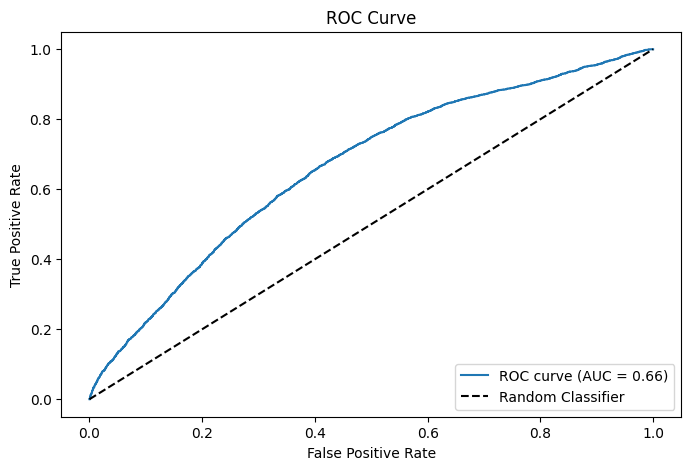

Epoch 2.0: AUROC = 0.71


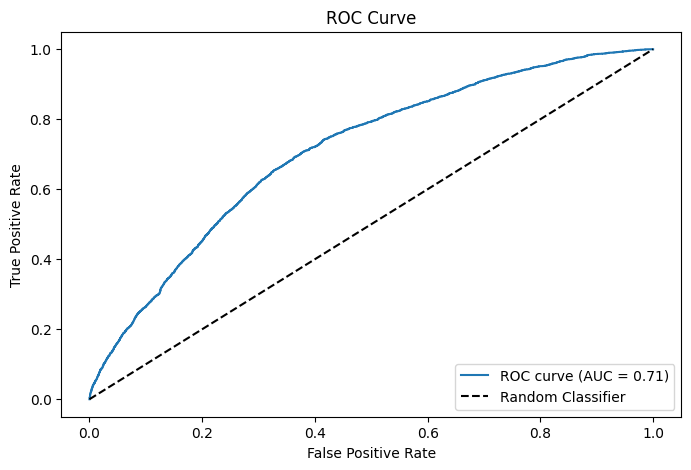

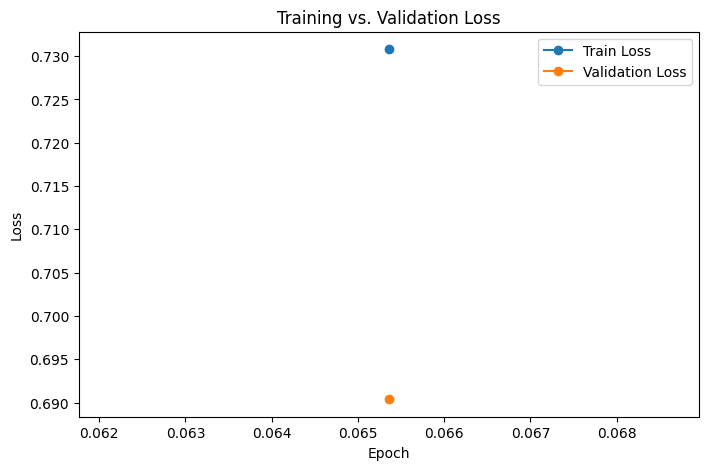

Epoch 3.0: AUROC = 0.90


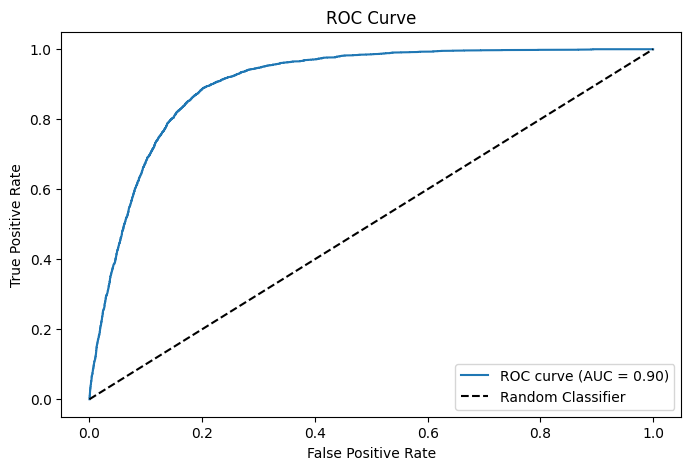

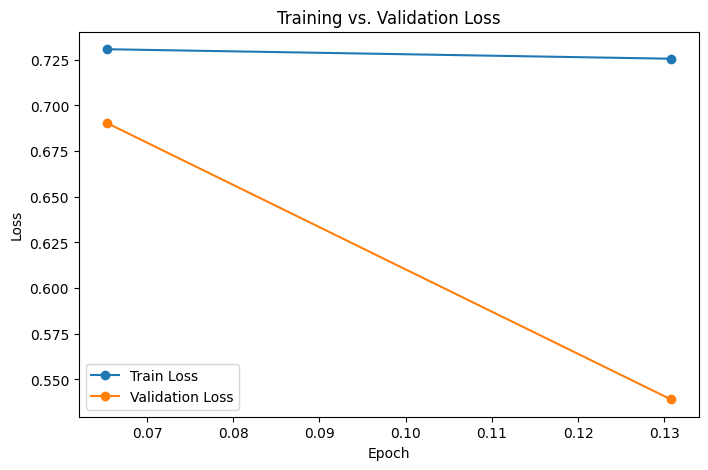

Model saved to ./fine_tuned_bert_with_lora


eval/accuracy,▆▁▇█
eval/f1,▁█▅▄
eval/loss,▆█▅▁
eval/precision,▁▃▅█
eval/recall,▁█▂▂
eval/runtime,▁██▇
eval/samples_per_second,█▁▂▂
eval/steps_per_second,█▁▁▁
test/accuracy,▆█▁▇█
test/f1,▁▁█▅▄
test/loss,▆▄█▅▁


In [ ]:
# Install necessary libraries (run these in Colab if not already installed)
!pip install peft wandb scipy

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import scipy.special

from transformers import BertTokenizerFast, BertForTokenClassification, Trainer, TrainingArguments, TrainerCallback
from peft import LoraConfig, get_peft_model, TaskType

import wandb

# -------------------------------
# Initialize wandb (optional; still used for run tracking)
# -------------------------------
wandb.init(project="fine_tuning_with_lora", config={"run_name": "bert_token_classification_with_lora"})

# -------------------------------
# Upload and Load Dataset
# -------------------------------
from google.colab import files
uploaded = files.upload()

file_path = list(uploaded.keys())[0]
df = pd.read_excel(file_path)
print("Dataset preview:")
print(df.head())

# Define column names (adjust if necessary)
text_column = df.columns[0]
keywords_column = df.columns[1]

# -------------------------------
# Tokenizer and Dataset Preparation
# -------------------------------
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

class KeywordDataset(Dataset):
    def __init__(self, texts, keywords, tokenizer, max_len):
        self.texts = texts
        self.keywords = keywords
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        keywords = self.keywords[idx]
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        labels = self._create_labels(text, keywords, encoding)
        # Squeeze tensors from shape [1, seq_len] to [seq_len]
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.long)
        return item

    def _create_labels(self, text, keywords, encoding):
        word_ids = encoding.word_ids()
        # Set -100 for special tokens and 0 for others initially
        labels = [-100 if i is None else 0 for i in word_ids]
        for keyword in keywords:
            keyword_tokens = self.tokenizer.tokenize(keyword)
            keyword_ids = self.tokenizer.convert_tokens_to_ids(keyword_tokens)
            for i, word_id in enumerate(word_ids):
                if word_id is None:
                    continue
                token_id = encoding["input_ids"][0][i].item()
                if token_id in keyword_ids:
                    labels[i] = 1
        return labels

# Split the dataset (80% train, 20% test)
texts = df[text_column].tolist()
# Assumes keywords in Excel are comma-separated strings
keywords = df[keywords_column].apply(lambda x: x.split(',')).tolist()
train_texts, test_texts, train_keywords, test_keywords = train_test_split(
    texts, keywords, test_size=0.2, random_state=42)

train_dataset = KeywordDataset(train_texts, train_keywords, tokenizer, max_len=128)
test_dataset = KeywordDataset(test_texts, test_keywords, tokenizer, max_len=128)

# -------------------------------
# Load Pre-trained Model and Wrap with LoRA Layers
# -------------------------------
model = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.config.hidden_dropout_prob = 0.3  # Increase dropout to reduce overfitting

# Configure LoRA: target the "query" and "value" modules
lora_config = LoraConfig(
    task_type=TaskType.TOKEN_CLS,
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["query", "value"]
)

# Wrap the BERT model with LoRA layers
model = get_peft_model(model, lora_config)
print("LoRA Model:")
print(model)

# -------------------------------
# Training Arguments and Metrics Function
# -------------------------------
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.005,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    save_total_limit=2,
    load_best_model_at_end=True,
    learning_rate=1e-5,
    run_name="bert_token_classification_with_lora"  # distinct run name
)

def compute_metrics(pred):
    labels = pred.label_ids.flatten()
    preds = pred.predictions.argmax(-1).flatten()
    mask = labels != -100
    labels = labels[mask]
    preds = preds[mask]
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    accuracy = (labels == preds).mean()
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}

# -------------------------------
# Evaluation Function for AUROC
# -------------------------------
def evaluate_roc(trainer, eval_dataset):
    # Get predictions from the trainer
    pred_output = trainer.predict(eval_dataset)
    logits = pred_output.predictions  # shape: (num_examples, seq_len, num_labels)
    labels = pred_output.label_ids     # shape: (num_examples, seq_len)

    # Flatten predictions and labels, ignoring tokens with label -100
    mask = labels != -100
    flat_labels = labels[mask]
    flat_logits = logits[mask]

    # Compute softmax probabilities and extract probability for class 1
    probs = scipy.special.softmax(flat_logits, axis=-1)[:, 1]

    # Compute AUROC and ROC curve
    auc = roc_auc_score(flat_labels, probs)
    fpr, tpr, _ = roc_curve(flat_labels, probs)
    return auc, fpr, tpr

# -------------------------------
# Custom Callback to Plot AUROC and Loss Curves with matplotlib
# -------------------------------
class CustomPlotCallback(TrainerCallback):
    def __init__(self):
        self.trainer_ref = None
        self.train_losses = []
        self.val_losses = []
        self.epochs = []

    def set_trainer(self, trainer):
        self.trainer_ref = trainer

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if "loss" in logs:
                self.train_losses.append(logs["loss"])
            if "eval_loss" in logs:
                self.val_losses.append(logs["eval_loss"])
            if "epoch" in logs:
                self.epochs.append(logs["epoch"])

    def on_epoch_end(self, args, state, control, **kwargs):
        # Use the stored trainer reference
        trainer = self.trainer_ref
        if trainer is None:
            trainer = kwargs.get("trainer")
        if trainer is None:
            return control

        auc, fpr, tpr = evaluate_roc(trainer, test_dataset)
        print(f"Epoch {state.epoch}: AUROC = {auc:.2f}")

        # Plot ROC Curve
        plt.figure(figsize=(8, 5))
        plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.2f})")
        plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend(loc="lower right")
        plt.show()

        # Ensure the arrays have the same length before plotting loss curves
        min_len = min(len(self.epochs), len(self.train_losses), len(self.val_losses))
        if min_len > 0:
            plt.figure(figsize=(8, 5))
            plt.plot(self.epochs[:min_len], self.train_losses[:min_len], marker='o', label="Train Loss")
            plt.plot(self.epochs[:min_len], self.val_losses[:min_len], marker='o', label="Validation Loss")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.title("Training vs. Validation Loss")
            plt.legend()
            plt.show()

        return control

# -------------------------------
# Initialize Trainer and Start Training
# -------------------------------
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Create and add our custom callback
custom_callback = CustomPlotCallback()
trainer.add_callback(custom_callback)
custom_callback.set_trainer(trainer)

trainer.train()

# -------------------------------
# Merge LoRA Layers and Save the Final Model
# -------------------------------
model = model.merge_and_unload()
model_save_path = "./fine_tuned_bert_with_lora"
model.save_pretrained(model_save_path)
trainer.save_model(model_save_path)
print("Model saved to", model_save_path)

wandb.finish()


In [ ]:
!pip install sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

### **Testing with Fine tuned Bert and Sbert**

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer
from transformers import BertTokenizerFast, BertForTokenClassification
from sentence_transformers import SentenceTransformer
import torch
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import random
import string

# Download required nltk data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('stopwords')

# Initialize the WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Stopwords set
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

# Function to get the POS tag for accurate lemmatization
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

# Function to join subword tokens
def join_tokens(tokens):
    words = []
    current_word = ''
    for token in tokens:
        if token.startswith("##"):
            current_word += token[2:]
        else:
            if current_word:
                words.append(current_word)
            current_word = token
    if current_word:
        words.append(current_word)
    return words

# Load the fine-tuned model and tokenizer for BERT
model_save_path = "./fine_tuned_keyword_extraction_model1"
loaded_model = BertForTokenClassification.from_pretrained(model_save_path)
loaded_tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Load SBERT model for sentence embeddings
sbert_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Define the function to predict keywords for a given paragraph
def predict_keywords(paragraph, model, tokenizer, max_len=128):
    model.eval()
    inputs = tokenizer(paragraph, padding='max_length', truncation=True, max_length=max_len, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predictions = logits.argmax(-1).squeeze().tolist()
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"].squeeze().tolist())
    full_words = join_tokens(tokens)
    keywords = [word for word, pred in zip(full_words, predictions) if pred == 1 and word != '[PAD]']
    lemmatized_keywords = {lemmatizer.lemmatize(keyword.lower(), get_wordnet_pos(keyword)) for keyword in keywords}
    filtered_keywords = lemmatized_keywords - stop_words - punctuation
    return filtered_keywords

# Function to find sentences containing the keywords
def find_sentences_with_keywords(paragraph, keywords):
    sentences = paragraph.split('. ')
    return [sentence for sentence in sentences if any(keyword in sentence.lower() for keyword in keywords)]

# Function to compute SBERT embedding
def get_sbert_embedding(sentence, model):
    return model.encode(sentence)

# Function to compute BERT token-level embedding
def get_bert_embedding(sentence, model, tokenizer):
    inputs = tokenizer(sentence, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model.bert(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# Function to combine SBERT and BERT embeddings, ensuring same dimensions
def get_combined_embedding(sentence, sbert_model, bert_model, tokenizer):
    sbert_embedding = get_sbert_embedding(sentence, sbert_model)
    bert_embedding = get_bert_embedding(sentence, bert_model, tokenizer)

    # Check the shape of SBERT and BERT embeddings, adjust if needed
    if sbert_embedding.shape != bert_embedding.shape:
        # If the shapes are different, we resize the larger embedding to match the smaller one
        min_dim = min(sbert_embedding.shape[0], bert_embedding.shape[0])
        sbert_embedding = sbert_embedding[:min_dim]
        bert_embedding = bert_embedding[:min_dim]

    return np.mean([sbert_embedding, bert_embedding], axis=0)

# Function to compute the average embedding from a list of sentences
def get_average_embedding(sentences, sbert_model, bert_model, tokenizer):
    embeddings = [get_combined_embedding(sentence, sbert_model, bert_model, tokenizer) for sentence in sentences]
    return np.mean(embeddings, axis=0)

# Function to calculate the threshold based on k value
def calculate_dynamic_threshold(similarity_scores, k):
    mean_similarity = np.mean(similarity_scores)
    std_similarity = np.std(similarity_scores)
    return mean_similarity + k * std_similarity

# Function to use the calculated threshold and identify relevant sentences
def filter_relevant_sentences(similarity_scores, sentences, threshold):
    relevant_sentences = []
    for i, score in enumerate(similarity_scores):
        if score >= threshold:
            relevant_sentences.append(sentences[i])
    return relevant_sentences

# Function to perform grid search over k to find the optimal threshold and then filter relevant sentences
def group_sentences_by_relevance_dynamic(filtered_sentences, sample_sentences, k_values, alpha=1.0, beta=1.0):
    avg_embedding = get_average_embedding(sample_sentences, sbert_model, loaded_model, loaded_tokenizer)
    similarity_scores = []

    for sentence in filtered_sentences:
        combined_embedding = get_combined_embedding(sentence, sbert_model, loaded_model, loaded_tokenizer)
        similarity = cosine_similarity([avg_embedding], [combined_embedding])[0][0]
        print(sentence, " : ", similarity)
        similarity_scores.append(similarity)

    best_k = None
    best_score = -np.inf
    best_threshold = None

    for k in k_values:
        dynamic_threshold = calculate_dynamic_threshold(similarity_scores, k)
        relevant_indices = [i for i, score in enumerate(similarity_scores) if score >= dynamic_threshold]

        if len(relevant_indices) > 0:
            cohesion = np.mean([similarity_scores[i] for i in relevant_indices])
            irrelevant_indices = [i for i in range(len(similarity_scores)) if i not in relevant_indices]
            if irrelevant_indices:
                separation = np.mean([
                    np.mean([similarity_scores[i] for i in irrelevant_indices]) for i in relevant_indices
                ])
                # separation = np.mean([similarity_scores[i] for i in irrelevant_indices])
            else:
                separation = 0
            score = alpha * cohesion - beta * separation
            if score > best_score:
                best_score = score
                best_k = k
                best_threshold = dynamic_threshold

    relevant_sentences = filter_relevant_sentences(similarity_scores, filtered_sentences, best_threshold)

    return relevant_sentences, best_threshold, best_k

# Example usage of the predict_keywords function
example_paragraph = "Operating systems manage hardware and software resources. In a garden, the soil's 'memory' holds water and nutrients. OS multitasking allows running multiple applications simultaneously. A 'process' in cooking requires careful timing. File systems organize data on storage devices. The 'kernel' of a popcorn is the part that pops when heated."
predicted_keywords = predict_keywords(example_paragraph, loaded_model, loaded_tokenizer)
print("Predicted Keywords:", predicted_keywords)

# Find and print sentences with the predicted keywords
sentences_with_keywords = find_sentences_with_keywords(example_paragraph, predicted_keywords)
print("Sentences with Keywords:")
for sentence in sentences_with_keywords:
    print(sentence)

# Sample 20 random sentences from a hypothetical OS dataset for relevance computation
os_dataset = [
    "The operating system manages hardware resources and provides services for application software.",
    "OS multitasking allows multiple processes to share CPU resources effectively.",
    "File systems in OS organize how data is stored and retrieved.",
    "Memory management in OS involves allocating space to processes as needed.",
    "Process scheduling in OS determines the order of execution for processes.",
    "OS security mechanisms protect data and resources from unauthorized access.",
    "Virtual memory in OS enables the execution of processes that may not be entirely in physical memory.",
    "Drivers are essential for OS to interact with hardware devices.",
    "OS user interfaces provide a way for users to interact with the system.",
    "Kernel space and user space are two separate areas in OS memory.",
    "An interrupt is a signal that prompts the OS to stop and figure out how to respond.",
    "OS handles input/output operations to communicate with peripheral devices.",
    "In OS, a deadlock can occur when multiple processes wait for resources held by each other.",
    "Virtualization allows multiple OS to run on a single physical machine.",
    "The bootloader initializes the OS during startup.",
    "Swapping in OS is a technique for managing memory use.",
    "Threads in OS are the smallest sequence of programmed instructions.",
    "OS provides APIs for software developers to interact with hardware.",
    "Disk management in OS involves handling data storage on hard drives.",
    "OS logging systems keep records of system and user activities."
]

# Randomly select 20 sentences from the OS dataset
sample_sentences = random.sample(os_dataset, 20)

# Define the range of k values for the grid search
k_values = np.arange(0.0, 2.0, 0.05)  # Finer grid for more accurate threshold

# Group and print sentences relevant to the sampled OS sentences using a dynamic threshold
relevant_sentences_dynamic_diff, dynamic_threshold_diff, best_k_diff = group_sentences_by_relevance_dynamic(
    sentences_with_keywords, sample_sentences, k_values, alpha=1.0, beta=1.0)

print("\nBest k :", best_k_diff)
print("Dynamic Threshold :", dynamic_threshold_diff)
print("\nRelevant Sentences to OS topic (Dynamic):")
for sentence in relevant_sentences_dynamic_diff:
    print(sentence)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Predicted Keywords: {'multitasking', 'data', 'software', 'resource', 'system', 'run', 'hardware', 'memory', 'allows'}
Sentences with Keywords:
Operating systems manage hardware and software resources
In a garden, the soil's 'memory' holds water and nutrients
OS multitasking allows running multiple applications simultaneously
File systems organize data on storage devices
Operating systems manage hardware and software resources  :  0.7764494
In a garden, the soil's 'memory' holds water and nutrients  :  0.3619828
OS multitasking allows running multiple applications simultaneously  :  0.70605874
File systems organize data on storage devices  :  0.69857323

Best k : 0.0
Dynamic Threshold : 0.6357660293579102

Relevant Sentences to OS topic (Dynamic):
Operating systems manage hardware and software resources
OS multitasking allows running multiple applications simultaneously
File systems organize data on storage devices


## **Fine tuning Sbert with LoRA for scoring sentences based on the relevance to the interested topic**

Enter your WandB API key: ··········


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Please upload your Excel file with columns 'Paragraph' and 'Label'


Saving OS_sentences (3).xlsx to OS_sentences (3).xlsx


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

trainable params: 110,592 || all params: 22,823,808 || trainable%: 0.4845
Starting LoRA Fine-Tuning...

Epoch 1/5


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1 Train Loss: 1.4074
Epoch 1 Validation Loss: 0.9309

Epoch 2/5


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 2 Train Loss: 1.0023
Epoch 2 Validation Loss: 0.7161

Epoch 3/5


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 3 Train Loss: 0.8298
Epoch 3 Validation Loss: 0.4670

Epoch 4/5


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 4 Train Loss: 0.5506
Epoch 4 Validation Loss: 0.2930

Epoch 5/5


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 5 Train Loss: 0.3183
Epoch 5 Validation Loss: 0.2167
Merged model saved to fine_tuned_sbert_lora_merged
Validation AUROC: 0.9847


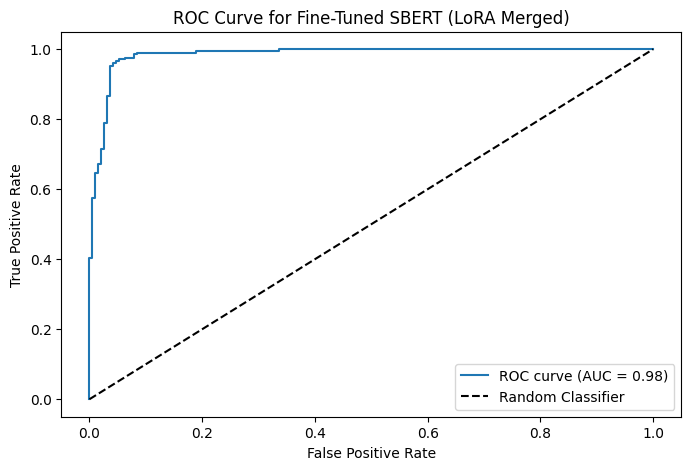

<Figure size 640x480 with 0 Axes>

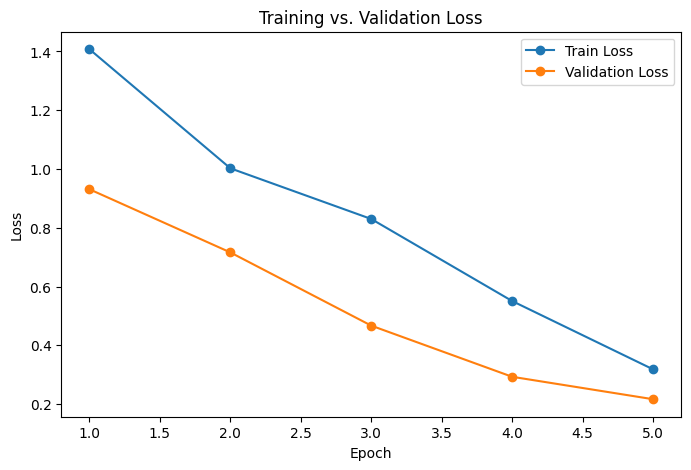

<Figure size 640x480 with 0 Axes>

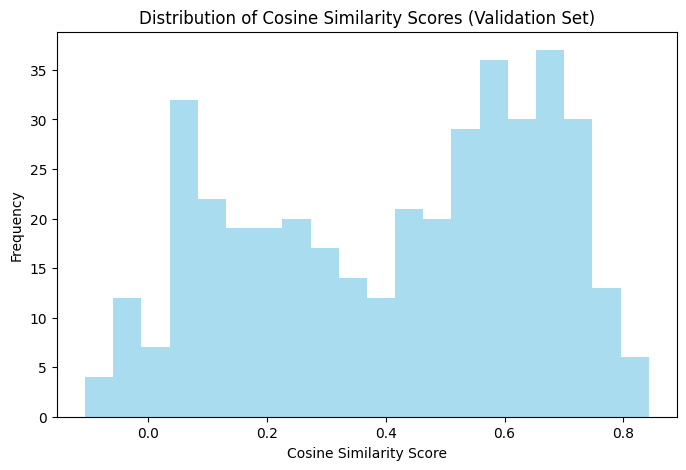

AUROC,▁
epoch,▁▃▅▆█
eval/accuracy,▁▇█
eval/f1,▁▇█
eval/loss,█▂▁
eval/precision,▁██
eval/recall,▁▆█
eval/runtime,▁▆█
eval/samples_per_second,█▃▁
eval/steps_per_second,█▃▁
train/epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████


<Figure size 640x480 with 0 Axes>

In [ ]:
import pandas as pd
import numpy as np
import random
import os
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import getpass
import wandb

from sentence_transformers import SentenceTransformer, InputExample, losses
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics.pairwise import cosine_similarity
from peft import get_peft_model, LoraConfig, TaskType

# -------------------------------
# WandB Setup
# -------------------------------
wandb_api_key = getpass.getpass("Enter your WandB API key: ")
wandb.login(key=wandb_api_key)
run = wandb.init(project="sbert_finetune_os", config={
    "model_name": "paraphrase-MiniLM-L6-v2",
    "batch_size": 16,
    "epochs": 5,
    "warmup_proportion": 0.1,
    "learning_rate": 1e-5
})
config = wandb.config
model_name = config.get("model_name", "paraphrase-MiniLM-L6-v2")
batch_size = config.get("batch_size", 16)
num_epochs = config.get("epochs", 5)
warmup_proportion = config.get("warmup_proportion", 0.1)
learning_rate = config.get("learning_rate", 1e-5)

# -------------------------------
# Step 1: Upload Excel file and load data
# -------------------------------
print("Please upload your Excel file with columns 'Paragraph' and 'Label'")
from google.colab import files
uploaded = files.upload()
excel_path = list(uploaded.keys())[0]

df = pd.read_excel(excel_path)
if not set(["Sentence", "Label"]).issubset(df.columns):
    raise ValueError("Excel file must contain 'Sentence' and 'Label' columns.")

# For contrastive setup, we create InputExample pairs from paragraphs.
paragraphs = df["Sentence"].tolist()
labels = df["Label"].astype(str).tolist()  # binary string labels (e.g., "10101")

# Split paragraphs into two groups based on a heuristic (more "1"s are OS-relevant)
os_paragraphs = [para for para, lab in zip(paragraphs, labels) if lab.count("1") > lab.count("0")]
non_os_paragraphs = [para for para, lab in zip(paragraphs, labels) if lab.count("1") <= lab.count("0")]

# -------------------------------
# Step 2: Create pairwise training examples
# -------------------------------
positive_examples = []
negative_examples = []

# Positive pairs: both paragraphs OS-relevant
num_positive = 1000
for _ in range(num_positive):
    p1, p2 = random.sample(os_paragraphs, 2)
    positive_examples.append(InputExample(texts=[p1, p2], label=1.0))

# Negative pairs: one OS-relevant with one non-OS
num_negative = 1000
for _ in range(num_negative):
    p1 = random.choice(os_paragraphs)
    p2 = random.choice(non_os_paragraphs)
    negative_examples.append(InputExample(texts=[p1, p2], label=0.0))

all_examples = positive_examples + negative_examples
random.shuffle(all_examples)

# Split into training and validation sets (80/20)
split_index = int(0.8 * len(all_examples))
train_data = all_examples[:split_index]
eval_data = all_examples[split_index:]

# -------------------------------
# Step 3: Load pre-trained SBERT model and apply LoRA
# -------------------------------
base_model = SentenceTransformer(model_name)

lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["query", "key", "value"],
    task_type=TaskType.FEATURE_EXTRACTION,
    bias="none"
)

model = get_peft_model(base_model, lora_config)
model.print_trainable_parameters()

# IMPORTANT: Override model.forward to pass the features dictionary as the 'input' keyword argument.
original_forward = model.forward
model.forward = lambda features, labels=None: original_forward(input=features)

# Use the built-in smart_batching_collate (returns tuple: (features, labels))
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size,
                              collate_fn=base_model.smart_batching_collate)
val_dataloader = DataLoader(eval_data, batch_size=batch_size,
                            collate_fn=base_model.smart_batching_collate)

train_loss = losses.OnlineContrastiveLoss(model=model)
warmup_steps = int(len(train_dataloader) * num_epochs * warmup_proportion)

# -------------------------------
# Step 4: Fine tune the model with wandb logging
# -------------------------------
model.train()
optimizer = AdamW(model.parameters(), lr=learning_rate)
train_losses = []
val_losses = []
loss_values = []

print("Starting LoRA Fine-Tuning...")
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    epoch_loss = 0
    progress_bar = tqdm(train_dataloader, desc="Training")
    for batch in progress_bar:
        optimizer.zero_grad()
        if isinstance(batch, tuple):
            features, labels = batch
        else:
            features = batch
            labels = batch['labels']
        loss = train_loss(features, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())
        loss_values.append(loss.item())
    avg_train_loss = epoch_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1} Train Loss: {avg_train_loss:.4f}")

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_dataloader:
            if isinstance(batch, tuple):
                features, labels = batch
            else:
                features = batch
                labels = batch['labels']
            loss = train_loss(features, labels)
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1} Validation Loss: {avg_val_loss:.4f}")
    wandb.log({"epoch": epoch+1, "train_loss": avg_train_loss, "val_loss": avg_val_loss})
    model.train()

# Merge LoRA weights into the base model
merged_model = model.merge_and_unload()
merged_model.save_pretrained("fine_tuned_sbert_lora_merged")
print("Merged model saved to fine_tuned_sbert_lora_merged")

# -------------------------------
# Step 5: Evaluation and Plotting Graphs
# -------------------------------
def evaluate_model_roc(eval_examples, model):
    y_true = []
    y_scores = []
    cosine_scores = []
    for example in eval_examples:
        texts = example.texts
        embeddings = model.encode(texts)
        sim = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]
        y_scores.append(sim)
        y_true.append(example.label)
        cosine_scores.append(sim)
    auc = roc_auc_score(y_true, y_scores)
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    return auc, fpr, tpr, cosine_scores

auc, fpr, tpr, cosine_scores = evaluate_model_roc(eval_data, merged_model)
print(f"Validation AUROC: {auc:.4f}")
wandb.log({"AUROC": auc})

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Fine-Tuned SBERT (LoRA Merged)")
plt.legend(loc="lower right")
plt.show()
wandb.log({"ROC_Curve": wandb.Image(plt)})

plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs+1), train_losses, marker='o', label="Train Loss")
plt.plot(range(1, num_epochs+1), val_losses, marker='o', label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.show()
wandb.log({"Loss_Curve": wandb.Image(plt)})

plt.figure(figsize=(8, 5))
plt.hist(cosine_scores, bins=20, alpha=0.7, color='skyblue')
plt.xlabel("Cosine Similarity Score")
plt.ylabel("Frequency")
plt.title("Distribution of Cosine Similarity Scores (Validation Set)")
plt.show()
wandb.log({"Cosine_Histogram": wandb.Image(plt)})

wandb.finish()


## **Fine tuning Sbert(sft) for scoring sentences based on the relevance to the interested topic**

Enter your WandB API key: ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Please upload your Excel file with columns 'Sentence' and 'Label'


Saving OS_sentences (3).xlsx to OS_sentences (3) (4).xlsx
Starting Direct Fine-Tuning...

Epoch 1/5


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1 Train Loss: 0.0877
Epoch 1 Validation Loss: 0.0118

Epoch 2/5


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 2 Train Loss: 0.0059
Epoch 2 Validation Loss: 0.0054

Epoch 3/5


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 3 Train Loss: 0.0000
Epoch 3 Validation Loss: 0.0054

Epoch 4/5


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 4 Train Loss: 0.0042
Epoch 4 Validation Loss: 0.0000

Epoch 5/5


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 5 Train Loss: 0.0013
Epoch 5 Validation Loss: 0.0000
Model saved to fine_tuned_sbert_sft
Validation AUROC: 0.9999


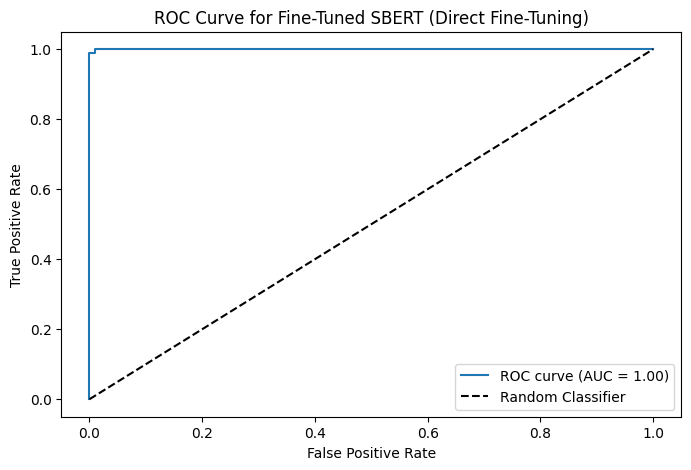

<Figure size 640x480 with 0 Axes>

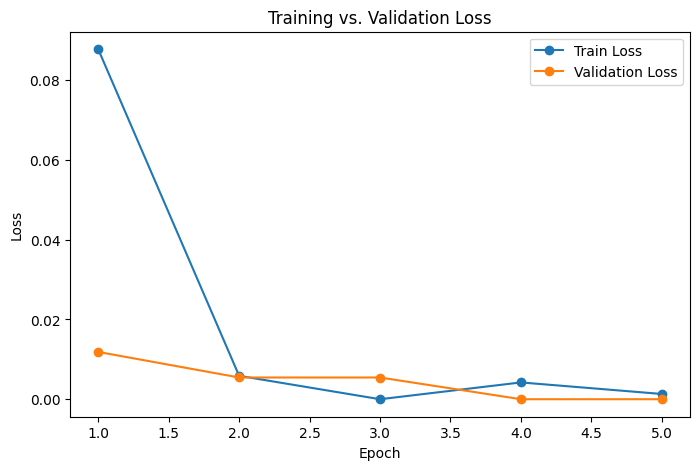

<Figure size 640x480 with 0 Axes>

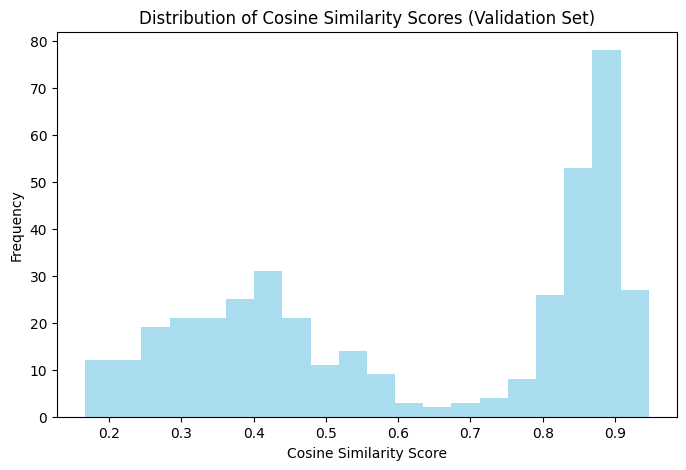

AUROC,▁
epoch,▁▃▅▆█
train_loss,█▁▁▁▁
val_loss,█▄▄▁▁
AUROC,0.9999
epoch,5
train_loss,0.00131
val_loss,0


<Figure size 640x480 with 0 Axes>

In [ ]:
import pandas as pd
import numpy as np
import random
import os
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import getpass
import wandb

from sentence_transformers import SentenceTransformer, InputExample, losses
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics.pairwise import cosine_similarity

# -------------------------------
# WandB Setup
# -------------------------------
wandb_api_key = getpass.getpass("Enter your WandB API key: ")
wandb.login(key=wandb_api_key)
run = wandb.init(project="sbert_finetune_os", config={
    "model_name": "all-MiniLM-L12-v2",
    "batch_size": 16,
    "epochs": 5,
    "warmup_proportion": 0.1,
    "learning_rate": 1e-5
})
config = wandb.config
model_name = config.get("model_name", "paraphrase-MiniLM-L6-v2")
batch_size = config.get("batch_size", 16)
num_epochs = config.get("epochs", 5)
warmup_proportion = config.get("warmup_proportion", 0.1)
learning_rate = config.get("learning_rate", 1e-5)

# -------------------------------
# Step 1: Upload Excel file and load data
# -------------------------------
print("Please upload your Excel file with columns 'Sentence' and 'Label'")
from google.colab import files
uploaded = files.upload()
excel_path = list(uploaded.keys())[0]

df = pd.read_excel(excel_path)
if not set(["Sentence", "Label"]).issubset(df.columns):
    raise ValueError("Excel file must contain 'Sentence' and 'Label' columns.")

# For contrastive setup, we create InputExample pairs from paragraphs.
paragraphs = df["Sentence"].tolist()
labels = df["Label"].astype(str).tolist()  # binary string labels (e.g., "10101")

# Split paragraphs into two groups based on a heuristic (more "1"s are OS-relevant)
os_paragraphs = [para for para, lab in zip(paragraphs, labels) if lab.count("1") > lab.count("0")]
non_os_paragraphs = [para for para, lab in zip(paragraphs, labels) if lab.count("1") <= lab.count("0")]

# -------------------------------
# Step 2: Create pairwise training examples
# -------------------------------
positive_examples = []
negative_examples = []

# Positive pairs: both paragraphs OS-relevant
num_positive = 1000
for _ in range(num_positive):
    p1, p2 = random.sample(os_paragraphs, 2)
    positive_examples.append(InputExample(texts=[p1, p2], label=1.0))

# Negative pairs: one OS-relevant with one non-OS
num_negative = 1000
for _ in range(num_negative):
    p1 = random.choice(os_paragraphs)
    p2 = random.choice(non_os_paragraphs)
    negative_examples.append(InputExample(texts=[p1, p2], label=0.0))

all_examples = positive_examples + negative_examples
random.shuffle(all_examples)

# Split into training and validation sets (80/20)
split_index = int(0.8 * len(all_examples))
train_data = all_examples[:split_index]
eval_data = all_examples[split_index:]

# -------------------------------
# Step 3: Load pre-trained SBERT model for Direct Fine-Tuning
# -------------------------------
model = SentenceTransformer(model_name)

# Use the built-in smart_batching_collate (returns tuple: (features, labels))
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size,
                              collate_fn=model.smart_batching_collate)
val_dataloader = DataLoader(eval_data, batch_size=batch_size,
                            collate_fn=model.smart_batching_collate)

train_loss = losses.OnlineContrastiveLoss(model=model)
warmup_steps = int(len(train_dataloader) * num_epochs * warmup_proportion)

# -------------------------------
# Step 4: Fine tune the model with wandb logging
# -------------------------------
model.train()
optimizer = AdamW(model.parameters(), lr=learning_rate)
train_losses = []
val_losses = []
loss_values = []

print("Starting Direct Fine-Tuning...")
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    epoch_loss = 0
    progress_bar = tqdm(train_dataloader, desc="Training")
    for batch in progress_bar:
        optimizer.zero_grad()
        if isinstance(batch, tuple):
            features, labels = batch
        else:
            features = batch
            labels = batch['labels']
        loss = train_loss(features, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())
        loss_values.append(loss.item())
    avg_train_loss = epoch_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1} Train Loss: {avg_train_loss:.4f}")

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_dataloader:
            if isinstance(batch, tuple):
                features, labels = batch
            else:
                features = batch
                labels = batch['labels']
            loss = train_loss(features, labels)
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1} Validation Loss: {avg_val_loss:.4f}")
    wandb.log({"epoch": epoch+1, "train_loss": avg_train_loss, "val_loss": avg_val_loss})
    model.train()

model.save_pretrained("fine_tuned_sbert_sft")
print("Model saved to fine_tuned_sbert_sft")

# -------------------------------
# Step 5: Evaluation and Plotting Graphs
# -------------------------------
def evaluate_model_roc(eval_examples, model):
    y_true = []
    y_scores = []
    cosine_scores = []
    for example in eval_examples:
        texts = example.texts
        embeddings = model.encode(texts)
        sim = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]
        y_scores.append(sim)
        y_true.append(example.label)
        cosine_scores.append(sim)
    auc = roc_auc_score(y_true, y_scores)
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    return auc, fpr, tpr, cosine_scores

auc, fpr, tpr, cosine_scores = evaluate_model_roc(eval_data, model)
print(f"Validation AUROC: {auc:.4f}")
wandb.log({"AUROC": auc})

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Fine-Tuned SBERT (Direct Fine-Tuning)")
plt.legend(loc="lower right")
plt.show()
wandb.log({"ROC_Curve": wandb.Image(plt)})

plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs+1), train_losses, marker='o', label="Train Loss")
plt.plot(range(1, num_epochs+1), val_losses, marker='o', label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.show()
wandb.log({"Loss_Curve": wandb.Image(plt)})

plt.figure(figsize=(8, 5))
plt.hist(cosine_scores, bins=20, alpha=0.7, color='skyblue')
plt.xlabel("Cosine Similarity Score")
plt.ylabel("Frequency")
plt.title("Distribution of Cosine Similarity Scores (Validation Set)")
plt.show()
wandb.log({"Cosine_Histogram": wandb.Image(plt)})

wandb.finish()


In [ ]:
!pip install --upgrade bitsandbytes
# !pip install --upgrade git+https://github.com/huggingface/peft.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 56.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [ ]:
!pip install --upgrade git+https://github.com/huggingface/peft.git

  Cloning https://github.com/huggingface/peft.git to /tmp/pip-req-build-fyk4m3s9
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/peft.git /tmp/pip-req-build-fyk4m3s9
  Resolved https://github.com/huggingface/peft.git to commit 3dd26682f49244645fe18e12052ec12b10661edc
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for peft: filename=peft-0.14.1.dev0-py3-none-any.whl size=395953 sha256=49ffd19455d3c5c24505aa792a6f8864be01ddbcc1cab9150106963d9234b98d
  Stored in directory: /tmp/pip-ephem-wheel-cache-d8qjb4c0/wheels/42/ec/c4/eb24dac74be83ba2ed4817037a784d1c775e317cb8de69963f
Successfully built peft
  Attempting uninstall: peft
    Found existing installation: peft 0.14.0
    Uninstalling peft-0.14.0:
      Successfully uninstalled peft-0.14.0


Enter your WandB API key: ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Please upload your Excel file with columns 'Sentence' and 'Label'


Saving OS_sentences (3).xlsx to OS_sentences (3) (2).xlsx
Starting Direct Fine-Tuning...

Epoch 1/5


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1 Train Loss: 0.2755
Epoch 1 Validation Loss: 0.0680

Epoch 2/5


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 2 Train Loss: 0.0380
Epoch 2 Validation Loss: 0.0457

Epoch 3/5


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 3 Train Loss: 0.0201
Epoch 3 Validation Loss: 0.0392

Epoch 4/5


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 4 Train Loss: 0.0067
Epoch 4 Validation Loss: 0.0367

Epoch 5/5


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 5 Train Loss: 0.0094
Epoch 5 Validation Loss: 0.0272
Model saved to fine_tuned_sbert_sft
Validation AUROC: 0.9956


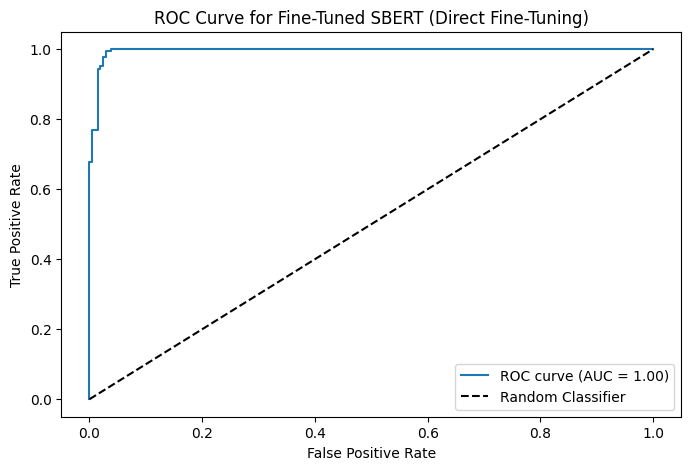

<Figure size 640x480 with 0 Axes>

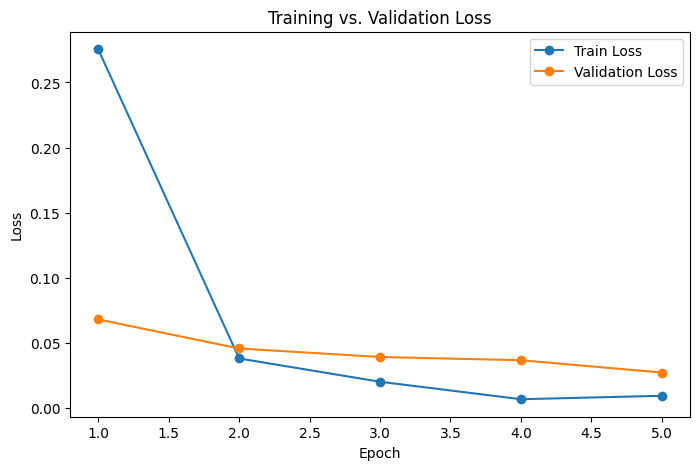

<Figure size 640x480 with 0 Axes>

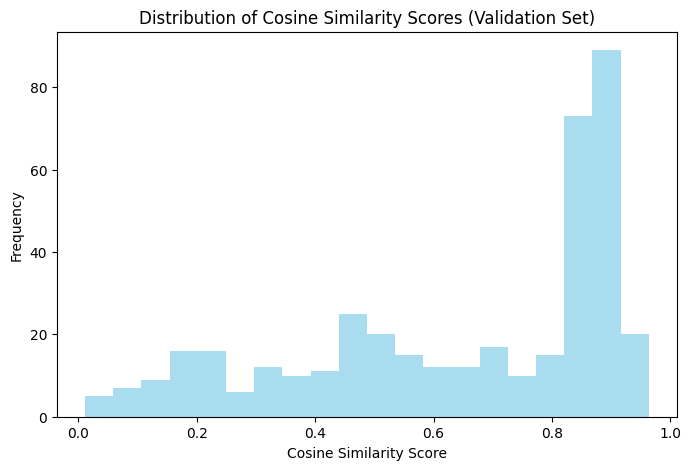

AUROC,▁
epoch,▁▃▅▆█
train_loss,█▂▁▁▁
val_loss,█▄▃▃▁
AUROC,0.99561
epoch,5
train_loss,0.00935
val_loss,0.0272


<Figure size 640x480 with 0 Axes>

In [ ]:
import pandas as pd
import numpy as np
import random
import os
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import getpass
import wandb

from sentence_transformers import SentenceTransformer, InputExample, losses
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics.pairwise import cosine_similarity

# -------------------------------
# WandB Setup
# -------------------------------
wandb_api_key = getpass.getpass("Enter your WandB API key: ")
wandb.login(key=wandb_api_key)
run = wandb.init(project="sbert_finetune_os", config={
    "model_name": "paraphrase-MiniLM-L6-v2",
    "batch_size": 16,
    "epochs": 5,
    "warmup_proportion": 0.1,
    "learning_rate": 1e-5
})
config = wandb.config
model_name = config.get("model_name", "paraphrase-MiniLM-L6-v2")
batch_size = config.get("batch_size", 16)
num_epochs = config.get("epochs", 5)
warmup_proportion = config.get("warmup_proportion", 0.1)
learning_rate = config.get("learning_rate", 1e-5)

# -------------------------------
# Step 1: Upload Excel file and load data
# -------------------------------
print("Please upload your Excel file with columns 'Sentence' and 'Label'")
from google.colab import files
uploaded = files.upload()
excel_path = list(uploaded.keys())[0]

df = pd.read_excel(excel_path)
if not set(["Sentence", "Label"]).issubset(df.columns):
    raise ValueError("Excel file must contain 'Sentence' and 'Label' columns.")

# For contrastive setup, we create InputExample pairs from paragraphs.
paragraphs = df["Sentence"].tolist()
labels = df["Label"].astype(str).tolist()  # binary string labels (e.g., "10101")

# Split paragraphs into two groups based on a heuristic (more "1"s are OS-relevant)
os_paragraphs = [para for para, lab in zip(paragraphs, labels) if lab.count("1") > lab.count("0")]
non_os_paragraphs = [para for para, lab in zip(paragraphs, labels) if lab.count("1") <= lab.count("0")]

# -------------------------------
# Step 2: Create pairwise training examples
# -------------------------------
positive_examples = []
negative_examples = []

# Positive pairs: both paragraphs OS-relevant
num_positive = 1000
for _ in range(num_positive):
    p1, p2 = random.sample(os_paragraphs, 2)
    positive_examples.append(InputExample(texts=[p1, p2], label=1.0))

# Negative pairs: one OS-relevant with one non-OS
num_negative = 1000
for _ in range(num_negative):
    p1 = random.choice(os_paragraphs)
    p2 = random.choice(non_os_paragraphs)
    negative_examples.append(InputExample(texts=[p1, p2], label=0.0))

all_examples = positive_examples + negative_examples
random.shuffle(all_examples)

# Split into training and validation sets (80/20)
split_index = int(0.8 * len(all_examples))
train_data = all_examples[:split_index]
eval_data = all_examples[split_index:]

# -------------------------------
# Step 3: Load pre-trained SBERT model for Direct Fine-Tuning
# -------------------------------
model = SentenceTransformer(model_name)

# Use the built-in smart_batching_collate (returns tuple: (features, labels))
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size,
                              collate_fn=model.smart_batching_collate)
val_dataloader = DataLoader(eval_data, batch_size=batch_size,
                            collate_fn=model.smart_batching_collate)

train_loss = losses.OnlineContrastiveLoss(model=model)
warmup_steps = int(len(train_dataloader) * num_epochs * warmup_proportion)

# -------------------------------
# Step 4: Fine tune the model with wandb logging
# -------------------------------
model.train()
optimizer = AdamW(model.parameters(), lr=learning_rate)
train_losses = []
val_losses = []
loss_values = []

print("Starting Direct Fine-Tuning...")
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    epoch_loss = 0
    progress_bar = tqdm(train_dataloader, desc="Training")
    for batch in progress_bar:
        optimizer.zero_grad()
        if isinstance(batch, tuple):
            features, labels = batch
        else:
            features = batch
            labels = batch['labels']
        loss = train_loss(features, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())
        loss_values.append(loss.item())
    avg_train_loss = epoch_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1} Train Loss: {avg_train_loss:.4f}")

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_dataloader:
            if isinstance(batch, tuple):
                features, labels = batch
            else:
                features = batch
                labels = batch['labels']
            loss = train_loss(features, labels)
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1} Validation Loss: {avg_val_loss:.4f}")
    wandb.log({"epoch": epoch+1, "train_loss": avg_train_loss, "val_loss": avg_val_loss})
    model.train()

model.save_pretrained("fine_tuned_sbert_sft")
print("Model saved to fine_tuned_sbert_sft")

# -------------------------------
# Step 5: Evaluation and Plotting Graphs
# -------------------------------
def evaluate_model_roc(eval_examples, model):
    y_true = []
    y_scores = []
    cosine_scores = []
    for example in eval_examples:
        texts = example.texts
        embeddings = model.encode(texts)
        sim = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]
        y_scores.append(sim)
        y_true.append(example.label)
        cosine_scores.append(sim)
    auc = roc_auc_score(y_true, y_scores)
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    return auc, fpr, tpr, cosine_scores

auc, fpr, tpr, cosine_scores = evaluate_model_roc(eval_data, model)
print(f"Validation AUROC: {auc:.4f}")
wandb.log({"AUROC": auc})

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Fine-Tuned SBERT (Direct Fine-Tuning)")
plt.legend(loc="lower right")
plt.show()
wandb.log({"ROC_Curve": wandb.Image(plt)})

plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs+1), train_losses, marker='o', label="Train Loss")
plt.plot(range(1, num_epochs+1), val_losses, marker='o', label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.show()
wandb.log({"Loss_Curve": wandb.Image(plt)})

plt.figure(figsize=(8, 5))
plt.hist(cosine_scores, bins=20, alpha=0.7, color='skyblue')
plt.xlabel("Cosine Similarity Score")
plt.ylabel("Frequency")
plt.title("Distribution of Cosine Similarity Scores (Validation Set)")
plt.show()
wandb.log({"Cosine_Histogram": wandb.Image(plt)})

wandb.finish()


## **Sentence Similarity Matrix with fine tuned Sbert**

In [ ]:
import torch
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Load the fine-tuned SBERT model
model_path = "fine_tuned_sbert_os"  # Adjust if saved in a different path
model = SentenceTransformer(model_path)

# Function to get embeddings from the fine-tuned model
def get_embeddings(sentences, model):
    embeddings = model.encode(sentences, convert_to_tensor=True)
    return embeddings

# Function to compute similarity between sentences
def compute_similarity(embeddings):
    similarity_matrix = cosine_similarity(embeddings.cpu().numpy())
    return similarity_matrix

# Input Paragraph (You can modify this)
paragraph = """
Modern operating systems optimize resource allocation by dynamically managing CPU and memory resources. The kernel coordinates complex hardware and software interactions to ensure system stability and efficiency. Efficient process scheduling in an OS enhances multitasking capabilities and responsiveness. File systems are designed to store and retrieve data with high efficiency and reliability. Robust security features in operating systems safeguard against unauthorized access and potential vulnerabilities.
"""

# Split the paragraph into sentences
sentences = [sent.strip() for sent in paragraph.split(".") if sent.strip()]

# Get sentence embeddings
sentence_embeddings = get_embeddings(sentences, model)

# Compute similarity matrix
similarity_matrix = compute_similarity(sentence_embeddings)

# Print sentence similarity results
print("\n🔹 Sentence Similarity Matrix:")
for i, sentence in enumerate(sentences):
    print(f"\nSentence {i+1}: {sentence}")
    for j in range(len(sentences)):
        if i != j:
            print(f"   ↪ Similarity with Sentence {j+1}: {similarity_matrix[i][j]:.4f}")

# Sort sentences based on similarity to the first sentence (assuming OS-related reference)
reference_index = 0  # You can change this to any other sentence index
sorted_indices = sorted(range(len(sentences)), key=lambda i: similarity_matrix[reference_index][i], reverse=True)

print("\n🔹 Sentences Ranked by Similarity to the First Sentence:")
for rank, idx in enumerate(sorted_indices, 1):
    print(f"{rank}. {sentences[idx]} (Similarity: {similarity_matrix[reference_index][idx]:.4f})")



🔹 Sentence Similarity Matrix:

Sentence 1: Modern operating systems optimize resource allocation by dynamically managing CPU and memory resources
   ↪ Similarity with Sentence 2: 0.8414
   ↪ Similarity with Sentence 3: 0.9211
   ↪ Similarity with Sentence 4: 0.8122
   ↪ Similarity with Sentence 5: 0.8721

Sentence 2: The kernel coordinates complex hardware and software interactions to ensure system stability and efficiency
   ↪ Similarity with Sentence 1: 0.8414
   ↪ Similarity with Sentence 3: 0.8357
   ↪ Similarity with Sentence 4: 0.7603
   ↪ Similarity with Sentence 5: 0.7925

Sentence 3: Efficient process scheduling in an OS enhances multitasking capabilities and responsiveness
   ↪ Similarity with Sentence 1: 0.9211
   ↪ Similarity with Sentence 2: 0.8357
   ↪ Similarity with Sentence 4: 0.7566
   ↪ Similarity with Sentence 5: 0.8299

Sentence 4: File systems are designed to store and retrieve data with high efficiency and reliability
   ↪ Similarity with Sentence 1: 0.8122
   ↪

## **Evaluating Fine tuned Bert with Sbert**

In [ ]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer
from transformers import BertTokenizerFast, BertForTokenClassification
from sentence_transformers import SentenceTransformer
import torch
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import string
from sklearn.metrics import precision_score, recall_score, f1_score
from google.colab import files

# Download required nltk data
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

# Initialize NLTK components
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

# Load fine-tuned BERT model and tokenizer for keyword extraction
model_save_path = "./fine_tuned_bert_with_lora"
loaded_model = BertForTokenClassification.from_pretrained(model_save_path)
loaded_tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Load SBERT model for sentence embeddings
sbert_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Function to extract keywords from a paragraph using the fine-tuned BERT model
def predict_keywords(paragraph, model, tokenizer, max_len=128):
    model.eval()
    inputs = tokenizer(paragraph, padding='max_length', truncation=True, max_length=max_len, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predictions = logits.argmax(-1).squeeze().tolist()
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"].squeeze().tolist())
    keywords = [lemmatizer.lemmatize(word.lower()) for word, pred in zip(tokens, predictions) if pred == 1 and word != '[PAD]']
    return set(keywords) - stop_words - punctuation

# Function to get sentences that contain at least one predicted keyword, using token-based matching
def find_sentences_with_keywords(paragraph, keywords):
    sentences = paragraph.split('. ')
    result = []
    for sentence in sentences:
        tokens = [lemmatizer.lemmatize(word.lower()) for word in word_tokenize(sentence) if word.isalpha()]
        # If at least one keyword is in the tokenized sentence, add it
        if any(keyword in tokens for keyword in keywords):
            result.append(sentence)
    return result

# Function to compute the fused embedding for a sentence using a weighted average of SBERT and BERT embeddings
def get_fused_embedding(sentence, sbert_model, bert_model, tokenizer):
    # Get SBERT embedding
    sbert_embedding = torch.tensor(sbert_model.encode(sentence), dtype=torch.float32)

    # Get BERT embedding: average over token embeddings
    encoded = tokenizer.encode(sentence, add_special_tokens=True, return_tensors="pt")
    with torch.no_grad():
        if hasattr(bert_model, 'bert'):
            bert_embeddings = bert_model.bert.embeddings.word_embeddings(encoded)
        else:
            bert_embeddings = bert_model.embeddings.word_embeddings(encoded)
    bert_embedding = bert_embeddings.mean(dim=1).squeeze()

    # Truncate embeddings to the same length if needed
    min_dim = min(sbert_embedding.shape[0], bert_embedding.shape[0])
    sbert_embedding, bert_embedding = sbert_embedding[:min_dim], bert_embedding[:min_dim]

    # Compute weighted average: 0.6 weight for SBERT, 0.4 for BERT
    fused_embedding = 0 * sbert_embedding + 1 * bert_embedding
    return fused_embedding.numpy()

# Function to compute the average embedding from a list of sentences using the fused embedding method
def get_average_embedding(sentences, sbert_model, bert_model, tokenizer):
    embeddings = [get_fused_embedding(sentence, sbert_model, bert_model, tokenizer) for sentence in sentences]
    return np.mean(embeddings, axis=0)

# Function to compute similarity scores and dynamically determine relevant key sentences
def group_sentences_by_relevance_dynamic(filtered_sentences, sample_sentences, k_values):
    if not filtered_sentences:
        return []

    avg_embedding = get_average_embedding(sample_sentences, sbert_model, loaded_model, loaded_tokenizer)
    similarity_scores = []
    for sentence in filtered_sentences:
        fused_embedding = get_fused_embedding(sentence, sbert_model, loaded_model, loaded_tokenizer)
        similarity = cosine_similarity([avg_embedding], [fused_embedding])[0][0]
        similarity_scores.append(similarity)

    if len(similarity_scores) == 0:
        return []

    # Grid search for best k (dynamic threshold)
    best_k, best_threshold, best_score = None, None, -np.inf
    for k in k_values:
        threshold = np.mean(similarity_scores) + k * np.std(similarity_scores)
        relevant_indices = [i for i, score in enumerate(similarity_scores) if score >= threshold]
        if relevant_indices:
            cohesion = np.mean([similarity_scores[i] for i in relevant_indices])
            separation = np.mean([similarity_scores[i] for i in range(len(similarity_scores)) if i not in relevant_indices])
            score = cohesion - separation
            if score > best_score:
                best_k, best_threshold, best_score = k, threshold, score

    if best_threshold is None:
        return []

    relevant_sentences = [filtered_sentences[i] for i, score in enumerate(similarity_scores) if score >= best_threshold]
    return relevant_sentences

# Function to generate a binary label (e.g., "10110") for the paragraph based on which sentences were selected as key
def generate_binary_label(paragraph, key_sentences):
    sentences = paragraph.split('. ')
    # Ensure the first sentence is always treated as key
    if sentences[0] not in key_sentences:
        key_sentences.append(sentences[0])
    return ''.join(['1' if sentence in key_sentences else '0' for sentence in sentences])

# Main evaluation function that loads the Excel file, predicts key sentences, and computes evaluation metrics
def evaluate_model(excel_path):
    df = pd.read_excel(excel_path)
    predicted_labels = []
    actual_labels = []

    for idx, row in df.iterrows():
        paragraph = row["Paragraph"]
        true_label = str(row["Label"]).strip()

        # Extract predicted keywords and the sentences containing them
        predicted_keywords = predict_keywords(paragraph, loaded_model, loaded_tokenizer)
        sentences_with_keywords = find_sentences_with_keywords(paragraph, predicted_keywords)

        # Use grid search over a range of k values to select relevant key sentences
        k_values = np.arange(-3, 3.0, 0.05)
        # Use the candidate sentences for both filtering and as the sample for average embedding
        relevant_sentences = group_sentences_by_relevance_dynamic(sentences_with_keywords, sentences_with_keywords, k_values)

        # Generate binary label from predicted key sentences
        predicted_label = generate_binary_label(paragraph, relevant_sentences)

        predicted_labels.append(predicted_label)
        actual_labels.append(true_label)

        print(f"\nParagraph {idx+1}:")
        print("Predicted Label:", predicted_label)
        print("Actual Label:   ", true_label)

    # Compute overall accuracy (average per paragraph label match)
    accuracy = np.mean([sum(p1 == p2 for p1, p2 in zip(pred, actual)) / len(actual)
                        for pred, actual in zip(predicted_labels, actual_labels)])

    # Flatten labels for precision, recall, and F1 score computation
    y_pred = [list(map(int, list(pred))) for pred in predicted_labels]
    y_true = [list(map(int, list(true))) for true in actual_labels]
    y_pred_flat = [bit for sublist in y_pred for bit in sublist]
    y_true_flat = [bit for sublist in y_true for bit in sublist]

    precision = precision_score(y_true_flat, y_pred_flat, average='binary')
    recall = recall_score(y_true_flat, y_pred_flat, average='binary')
    f1 = f1_score(y_true_flat, y_pred_flat, average='binary')

    print("\n--- Overall Evaluation Metrics ---")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")

# Upload the Excel file using Google Colab's file uploader
uploaded = files.upload()
file_path = list(uploaded.keys())[0]

# Run the evaluation on the uploaded Excel file
evaluate_model(file_path)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Loading adapter weights from ./fine_tuned_bert_with_lora l

Saving validation_set (3).xlsx to validation_set (3).xlsx


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 1:
Predicted Label: 11011
Actual Label:    11010


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 2:
Predicted Label: 11010
Actual Label:    10000


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 3:
Predicted Label: 11011
Actual Label:    11111


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 4:
Predicted Label: 10110
Actual Label:    10110


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 5:
Predicted Label: 11011
Actual Label:    11011


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 6:
Predicted Label: 10001
Actual Label:    10100


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 7:
Predicted Label: 11001
Actual Label:    11101


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 8:
Predicted Label: 10111
Actual Label:    10011


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 9:
Predicted Label: 11110
Actual Label:    11110


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 10:
Predicted Label: 11011
Actual Label:    11001


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 11:
Predicted Label: 10100
Actual Label:    11100


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 12:
Predicted Label: 11011
Actual Label:    10010


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 13:
Predicted Label: 10111
Actual Label:    10111


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 14:
Predicted Label: 11011
Actual Label:    11011


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 15:
Predicted Label: 10010
Actual Label:    10100


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 16:
Predicted Label: 11011
Actual Label:    11001


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 17:
Predicted Label: 10111
Actual Label:    10111


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 18:
Predicted Label: 11110
Actual Label:    11110


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 19:
Predicted Label: 10011
Actual Label:    10010


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 20:
Predicted Label: 11101
Actual Label:    10101


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 21:
Predicted Label: 10100
Actual Label:    10100


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 22:
Predicted Label: 11101
Actual Label:    11001


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 23:
Predicted Label: 10111
Actual Label:    10111


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 24:
Predicted Label: 10111
Actual Label:    10101


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 25:
Predicted Label: 11011
Actual Label:    11010


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 26:
Predicted Label: 11011
Actual Label:    10010


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 27:
Predicted Label: 10111
Actual Label:    10101


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 28:
Predicted Label: 10100
Actual Label:    11001


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 29:
Predicted Label: 11110
Actual Label:    11100


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 30:
Predicted Label: 11101
Actual Label:    10101


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 31:
Predicted Label: 10001
Actual Label:    10101


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 32:
Predicted Label: 10001
Actual Label:    10101


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 33:
Predicted Label: 11110
Actual Label:    10100


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 34:
Predicted Label: 11101
Actual Label:    10101

Paragraph 35:
Predicted Label: 10111
Actual Label:    10111

--- Overall Evaluation Metrics ---
Accuracy:  0.8114
Precision: 0.8033
Recall:    0.9159
F1 Score:  0.8559


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
!pip install peft datasets

Upload the Excel file containing 'Sentence' and 'Label'


Saving OS_sentences (3).xlsx to OS_sentences (3) (5).xlsx
trainable params: 110,592 || all params: 22,823,808 || trainable%: 0.4845
Starting LoRA Fine-Tuning...

Epoch 1/5


Training: 100%|██████████| 100/100 [01:34<00:00,  1.05it/s, loss=2.84]


Epoch 1 Train Loss: 1.5509
Epoch 1 Validation Loss: 1.1504

Epoch 2/5


Training: 100%|██████████| 100/100 [01:22<00:00,  1.21it/s, loss=1.75]


Epoch 2 Train Loss: 1.2202
Epoch 2 Validation Loss: 0.9036

Epoch 3/5


Training: 100%|██████████| 100/100 [01:24<00:00,  1.19it/s, loss=0]


Epoch 3 Train Loss: 0.8634
Epoch 3 Validation Loss: 0.5655

Epoch 4/5


Training: 100%|██████████| 100/100 [01:23<00:00,  1.20it/s, loss=0.489]


Epoch 4 Train Loss: 0.6179
Epoch 4 Validation Loss: 0.3432

Epoch 5/5


Training: 100%|██████████| 100/100 [01:22<00:00,  1.21it/s, loss=1.59]


Epoch 5 Train Loss: 0.4607
Epoch 5 Validation Loss: 0.2332
Model saved to fine_tuned_sbert_lora


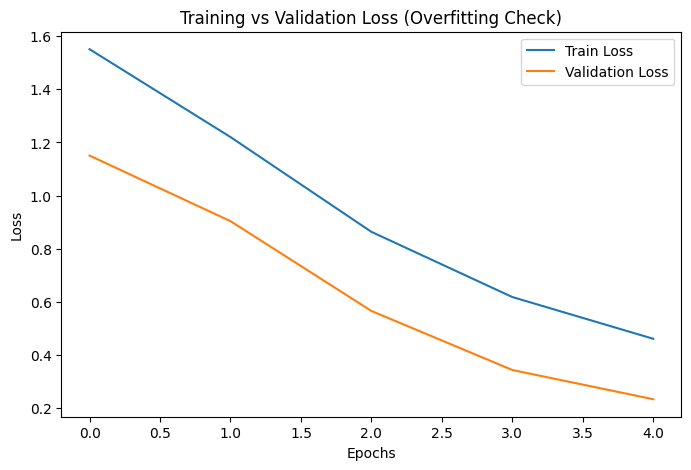

Validation AUROC: 0.9766


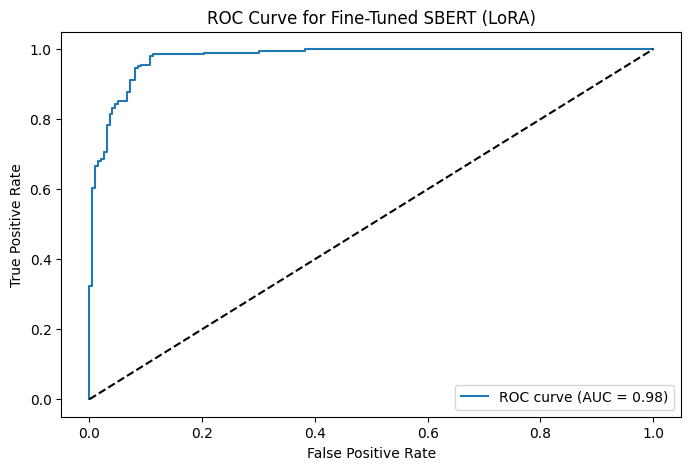

In [ ]:
import pandas as pd
import numpy as np
import random
import torch
import os
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer, InputExample, losses
from peft import get_peft_model, LoraConfig, TaskType
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from google.colab import files

# -----------------------------------
# 1️⃣ Upload & Load Dataset
# -----------------------------------
print("Upload the Excel file containing 'Sentence' and 'Label'")
uploaded = files.upload()
file_path = list(uploaded.keys())[0]

# Read the dataset
df = pd.read_excel(file_path)
if not set(["Sentence", "Label"]).issubset(df.columns):
    raise ValueError("Excel file must contain 'Sentence' and 'Label' columns.")

# Split sentences into OS-relevant (1) and non-OS (0)
os_sentences = df[df['Label'] == 1]['Sentence'].tolist()
non_os_sentences = df[df['Label'] == 0]['Sentence'].tolist()

# -----------------------------------
# 2️⃣ Prepare Pairwise Training Data
# -----------------------------------
train_examples = []
num_positive = 1000
num_negative = 1000

# Create positive pairs (OS relevant with OS relevant)
for _ in range(num_positive):
    s1, s2 = random.sample(os_sentences, 2)
    train_examples.append(InputExample(texts=[s1, s2], label=1.0))

# Create negative pairs (OS relevant with non-OS)
for _ in range(num_negative):
    s1 = random.choice(os_sentences)
    s2 = random.choice(non_os_sentences)
    train_examples.append(InputExample(texts=[s1, s2], label=0.0))

# Shuffle the dataset
random.shuffle(train_examples)

# Split into training & validation (80/20 split)
split_idx = int(0.8 * len(train_examples))
train_data = train_examples[:split_idx]
val_data = train_examples[split_idx:]

# -----------------------------------
# 3️⃣ Load Pre-trained SBERT & Apply LoRA
# -----------------------------------
model_name = "paraphrase-MiniLM-L6-v2"
model = SentenceTransformer(model_name)

# Define LoRA Configuration
lora_config = LoraConfig(
    r=8,                        # LoRA rank
    lora_alpha=32,              # Scaling factor
    lora_dropout=0.1,           # Dropout rate
    target_modules=["query", "key", "value"],  # LoRA applied to attention layers
    bias="none"
)

# Apply LoRA to SBERT
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()


# Define DataLoader
train_dataloader = DataLoader(
    train_data,
    shuffle=True,
    batch_size=16,
    collate_fn=model.smart_batching_collate  # FIX: Properly batches InputExample instances
)
val_dataloader = DataLoader(
    val_data,  # Validation dataset
    shuffle=False,
    batch_size=16,
    collate_fn=model.smart_batching_collate  # FIX: Convert InputExample to tensors
)

# Use Contrastive Loss
train_loss = losses.OnlineContrastiveLoss(model=model)

# -----------------------------------
# 4️⃣ Train the Model
# -----------------------------------
num_epochs = 5
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
train_losses = []
val_losses = []

print("Starting LoRA Fine-Tuning...")
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # Training loop
    model.train()
    total_train_loss = 0
    progress_bar = tqdm(train_dataloader, desc="Training")
    for batch in progress_bar:
        optimizer.zero_grad()
        features, labels = batch
        loss = train_loss(features, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1} Train Loss: {avg_train_loss:.4f}")

    # Validation loop
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_dataloader:
            features, labels = batch
            loss = train_loss(features, labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1} Validation Loss: {avg_val_loss:.4f}")

# Save the fine-tuned model
model_save_path = "fine_tuned_sbert_lora"
model.save_pretrained(model_save_path)
print(f"Model saved to {model_save_path}")

# -----------------------------------
# 5️⃣ Plot Metrics: Loss Curve & AUROC Curve
# -----------------------------------
# Plot Training & Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (Overfitting Check)")
plt.legend()
plt.show()

# Function to evaluate AUROC on validation set
def evaluate_model_roc(eval_examples, model):
    y_true = []
    y_scores = []
    for example in eval_examples:
        texts = example.texts
        embeddings = model.encode(texts)
        sim = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]
        y_scores.append(sim)
        y_true.append(example.label)
    auc = roc_auc_score(y_true, y_scores)
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    return auc, fpr, tpr

# Compute AUROC
auc, fpr, tpr = evaluate_model_roc(val_data, model)
print(f"Validation AUROC: {auc:.4f}")

# Plot ROC Curve
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')  # Random baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Fine-Tuned SBERT (LoRA)")
plt.legend(loc="lower right")
plt.show()


In [ ]:
from sentence_transformers import SentenceTransformer
from peft import PeftModel

# Load the base SBERT model
base_model = SentenceTransformer("paraphrase-MiniLM-L6-v2")

# Load the adapter weights (LoRA) from your fine-tuned folder
# This wraps the base model with the LoRA adapter.
model = PeftModel.from_pretrained(base_model, "./fine_tuned_sbert_lora")

# Test that the model is loaded by encoding a sample sentence:
sample_embedding = model.encode("This is a test sentence.")
print("Sample embedding shape:", sample_embedding.shape)


Sample embedding shape: (384,)


## **Evaluating fine tuned Bert and LoRA based fine tuned Sbert**

In [ ]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer
from transformers import BertTokenizerFast, BertForTokenClassification
from sentence_transformers import SentenceTransformer
import torch
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import string
from sklearn.metrics import precision_score, recall_score, f1_score
from google.colab import files

# Download required nltk data
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

# Initialize NLTK components
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

# Load fine-tuned BERT model and tokenizer for keyword extraction
model_save_path = "./fine_tuned_keyword_extraction_model1"
loaded_model = BertForTokenClassification.from_pretrained(model_save_path)
loaded_tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
base_model = SentenceTransformer("paraphrase-MiniLM-L6-v2")

# Load the adapter weights (LoRA) from your fine-tuned folder
# This wraps the base model with the LoRA adapter.

sbert_model = SentenceTransformer("./fine_tuned_sbert_lora_merged")

# Function to extract keywords from a paragraph using the fine-tuned BERT model
def predict_keywords(paragraph, model, tokenizer, max_len=128):
    model.eval()
    inputs = tokenizer(paragraph, padding='max_length', truncation=True, max_length=max_len, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predictions = logits.argmax(-1).squeeze().tolist()
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"].squeeze().tolist())
    keywords = [lemmatizer.lemmatize(word.lower()) for word, pred in zip(tokens, predictions) if pred == 1 and word != '[PAD]']
    return set(keywords) - stop_words - punctuation

# Function to get sentences that contain at least one predicted keyword, using token-based matching
def find_sentences_with_keywords(paragraph, keywords):
    sentences = paragraph.split('. ')
    result = []
    for sentence in sentences:
        tokens = [lemmatizer.lemmatize(word.lower()) for word in word_tokenize(sentence) if word.isalpha()]
        # If at least one keyword is in the tokenized sentence, add it
        if any(keyword in tokens for keyword in keywords):
            result.append(sentence)
    return result

# Function to compute the fused embedding for a sentence using a weighted average of SBERT and BERT embeddings
def get_fused_embedding(sentence, sbert_model, bert_model, tokenizer):
    # Get SBERT embedding
    sbert_embedding = torch.tensor(sbert_model.encode(sentence), dtype=torch.float32)

    # Get BERT embedding: average over token embeddings
    encoded = tokenizer.encode(sentence, add_special_tokens=True, return_tensors="pt")
    with torch.no_grad():
        if hasattr(bert_model, 'bert'):
            bert_embeddings = bert_model.bert.embeddings.word_embeddings(encoded)
        else:
            bert_embeddings = bert_model.embeddings.word_embeddings(encoded)
    bert_embedding = bert_embeddings.mean(dim=1).squeeze()

    # Truncate embeddings to the same length if needed
    min_dim = min(sbert_embedding.shape[0], bert_embedding.shape[0])
    sbert_embedding, bert_embedding = sbert_embedding[:min_dim], bert_embedding[:min_dim]

    # Compute weighted average: 0.6 weight for SBERT, 0.4 for BERT
    fused_embedding = 0.5 * sbert_embedding + 0.5 * bert_embedding
    return fused_embedding.numpy()

# Function to compute the average embedding from a list of sentences using the fused embedding method
def get_average_embedding(sentences, sbert_model, bert_model, tokenizer):
    embeddings = [get_fused_embedding(sentence, sbert_model, bert_model, tokenizer) for sentence in sentences]
    return np.mean(embeddings, axis=0)

# Function to compute similarity scores and dynamically determine relevant key sentences
def group_sentences_by_relevance_dynamic(filtered_sentences, sample_sentences, k_values):
    if not filtered_sentences:
        return []

    avg_embedding = get_average_embedding(sample_sentences, sbert_model, loaded_model, loaded_tokenizer)
    similarity_scores = []
    for sentence in filtered_sentences:
        fused_embedding = get_fused_embedding(sentence, sbert_model, loaded_model, loaded_tokenizer)
        similarity = cosine_similarity([avg_embedding], [fused_embedding])[0][0]
        similarity_scores.append(similarity)

    if len(similarity_scores) == 0:
        return []

    # Grid search for best k (dynamic threshold)
    best_k, best_threshold, best_score = None, None, -np.inf
    for k in k_values:
        threshold = np.mean(similarity_scores) + k * np.std(similarity_scores)
        relevant_indices = [i for i, score in enumerate(similarity_scores) if score >= threshold]
        if relevant_indices:
            cohesion = np.mean([similarity_scores[i] for i in relevant_indices])
            separation = np.mean([similarity_scores[i] for i in range(len(similarity_scores)) if i not in relevant_indices])
            score = cohesion - separation
            if score > best_score:
                best_k, best_threshold, best_score = k, threshold, score

    if best_threshold is None:
        return []

    relevant_sentences = [filtered_sentences[i] for i, score in enumerate(similarity_scores) if score >= best_threshold]
    return relevant_sentences

# Function to generate a binary label (e.g., "10110") for the paragraph based on which sentences were selected as key
def generate_binary_label(paragraph, key_sentences):
    sentences = paragraph.split('. ')
    # Ensure the first sentence is always treated as key
    if sentences[0] not in key_sentences:
        key_sentences.append(sentences[0])
    return ''.join(['1' if sentence in key_sentences else '0' for sentence in sentences])

def mean_cosine_similarity_accuracy(pred_labels, true_labels, threshold=0.8):
    correct = 0
    total = 0

    for pred, true in zip(pred_labels, true_labels):
        pred_vector = np.array([int(bit) for bit in pred])
        true_vector = np.array([int(bit) for bit in true])

        # Compute cosine similarity
        sim_score = cosine_similarity([pred_vector], [true_vector])[0][0]

        # If similarity >= threshold, consider it correct
        if sim_score >= threshold:
            correct += 1
        total += 1

    return correct / total if total > 0 else 0

# Main evaluation function that loads the Excel file, predicts key sentences, and computes evaluation metrics
def evaluate_model(excel_path):
    df = pd.read_excel(excel_path)
    predicted_labels = []
    actual_labels = []

    for idx, row in df.iterrows():
        paragraph = row["Paragraph"]
        true_label = str(row["Label"]).strip()

        # Extract predicted keywords and the sentences containing them
        predicted_keywords = predict_keywords(paragraph, loaded_model, loaded_tokenizer)
        sentences_with_keywords = find_sentences_with_keywords(paragraph, predicted_keywords)

        # Use grid search over a range of k values to select relevant key sentences
        k_values = np.arange(-3, 3.0, 0.05)
        # Use the candidate sentences for both filtering and as the sample for average embedding
        relevant_sentences = group_sentences_by_relevance_dynamic(sentences_with_keywords, sentences_with_keywords, k_values)

        # Generate binary label from predicted key sentences
        predicted_label = generate_binary_label(paragraph, relevant_sentences)

        predicted_labels.append(predicted_label)
        actual_labels.append(true_label)

        print(f"\nParagraph {idx+1}:")
        print("Predicted Label:", predicted_label)
        print("Actual Label:   ", true_label)

    # Compute overall accuracy (average per paragraph label match)
    accuracy = np.mean([sum(p1 == p2 for p1, p2 in zip(pred, actual)) / len(actual)
                        for pred, actual in zip(predicted_labels, actual_labels)])

    # Flatten labels for precision, recall, and F1 score computation
    y_pred = [list(map(int, list(pred))) for pred in predicted_labels]
    y_true = [list(map(int, list(true))) for true in actual_labels]
    y_pred_flat = [bit for sublist in y_pred for bit in sublist]
    y_true_flat = [bit for sublist in y_true for bit in sublist]

    precision = precision_score(y_true_flat, y_pred_flat, average='binary')
    recall = recall_score(y_true_flat, y_pred_flat, average='binary')
    f1 = f1_score(y_true_flat, y_pred_flat, average='binary')
    # Compute Mean Cosine Similarity Accuracy
    cosine_accuracy = mean_cosine_similarity_accuracy(predicted_labels, actual_labels)

    print("\n--- Overall Evaluation Metrics ---")
    print(f"Classification Accuracy:  {accuracy:.4f}")
    print(f"Precision:                {precision:.4f}")
    print(f"Recall:                   {recall:.4f}")
    print(f"F1 Score:                 {f1:.4f}")
    print(f"Mean Cosine Similarity Accuracy: {cosine_accuracy:.4f}")

# Upload the Excel file using Google Colab's file uploader
uploaded = files.upload()
file_path = list(uploaded.keys())[0]

# Run the evaluation on the uploaded Excel file
evaluate_model(file_path)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Saving validation_set (3).xlsx to validation_set (3) (17).xlsx


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 1:
Predicted Label: 11000
Actual Label:    11010


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 2:
Predicted Label: 10000
Actual Label:    10000


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 3:
Predicted Label: 11010
Actual Label:    11111


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 4:
Predicted Label: 10010
Actual Label:    10110


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 5:
Predicted Label: 11000
Actual Label:    11011


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 6:
Predicted Label: 10100
Actual Label:    10100


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 7:
Predicted Label: 10101
Actual Label:    11101


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 8:
Predicted Label: 10001
Actual Label:    10011


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 9:
Predicted Label: 11100
Actual Label:    11110


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 10:
Predicted Label: 10001
Actual Label:    11001


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 11:
Predicted Label: 11000
Actual Label:    11100


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 12:
Predicted Label: 10000
Actual Label:    10010


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 13:
Predicted Label: 10110
Actual Label:    10111


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 14:
Predicted Label: 11010
Actual Label:    11011


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 15:
Predicted Label: 10100
Actual Label:    10100


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 16:
Predicted Label: 11000
Actual Label:    11001


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 17:
Predicted Label: 10110
Actual Label:    10111


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 18:
Predicted Label: 11110
Actual Label:    11110


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 19:
Predicted Label: 10010
Actual Label:    10010


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 20:
Predicted Label: 10100
Actual Label:    10101


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 21:
Predicted Label: 10100
Actual Label:    10100


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 22:
Predicted Label: 11000
Actual Label:    11001


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 23:
Predicted Label: 10010
Actual Label:    10111


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 24:
Predicted Label: 10100
Actual Label:    10101


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 25:
Predicted Label: 10010
Actual Label:    11010


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 26:
Predicted Label: 10010
Actual Label:    10010


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 27:
Predicted Label: 10100
Actual Label:    10101


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 28:
Predicted Label: 11000
Actual Label:    11001


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 29:
Predicted Label: 10100
Actual Label:    11100


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 30:
Predicted Label: 10101
Actual Label:    10101


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 31:
Predicted Label: 10100
Actual Label:    10101


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 32:
Predicted Label: 10001
Actual Label:    10101


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 33:
Predicted Label: 10100
Actual Label:    10100


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 34:
Predicted Label: 10101
Actual Label:    10101

Paragraph 35:
Predicted Label: 10101
Actual Label:    10111

--- Overall Evaluation Metrics ---
Classification Accuracy:  0.8400
Precision:                1.0000
Recall:                   0.7383
F1 Score:                 0.8495
Mean Cosine Similarity Accuracy: 0.8857


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


## **Evaluating Fine tuned Bert and Fine tuned Sbert(both SFT)**

In [ ]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer
from transformers import BertTokenizerFast, BertForTokenClassification
from sentence_transformers import SentenceTransformer
import torch
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import string
from sklearn.metrics import precision_score, recall_score, f1_score
from google.colab import files

# Download required nltk data
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

# Initialize NLTK components
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

# Load fine-tuned BERT model and tokenizer for keyword extraction
model_save_path = "./fine_tuned_keyword_extraction_model1"
loaded_model = BertForTokenClassification.from_pretrained(model_save_path)
loaded_tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
base_model = SentenceTransformer("paraphrase-MiniLM-L6-v2")

# Load the adapter weights (LoRA) from your fine-tuned folder
# This wraps the base model with the LoRA adapter.

sbert_model = SentenceTransformer("./fine_tuned_sbert_sft")

# Function to extract keywords from a paragraph using the fine-tuned BERT model
def predict_keywords(paragraph, model, tokenizer, max_len=128):
    model.eval()
    inputs = tokenizer(paragraph, padding='max_length', truncation=True, max_length=max_len, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predictions = logits.argmax(-1).squeeze().tolist()
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"].squeeze().tolist())
    keywords = [lemmatizer.lemmatize(word.lower()) for word, pred in zip(tokens, predictions) if pred == 1 and word != '[PAD]']
    return set(keywords) - stop_words - punctuation

# Function to get sentences that contain at least one predicted keyword, using token-based matching
def find_sentences_with_keywords(paragraph, keywords):
    sentences = paragraph.split('. ')
    result = []
    for sentence in sentences:
        tokens = [lemmatizer.lemmatize(word.lower()) for word in word_tokenize(sentence) if word.isalpha()]
        # If at least one keyword is in the tokenized sentence, add it
        if any(keyword in tokens for keyword in keywords):
            result.append(sentence)
    return result

# Function to compute the fused embedding for a sentence using a weighted average of SBERT and BERT embeddings
def get_fused_embedding(sentence, sbert_model, bert_model, tokenizer):
    # Get SBERT embedding
    sbert_embedding = torch.tensor(sbert_model.encode(sentence), dtype=torch.float32)

    # Get BERT embedding: average over token embeddings
    encoded = tokenizer.encode(sentence, add_special_tokens=True, return_tensors="pt")
    with torch.no_grad():
        if hasattr(bert_model, 'bert'):
            bert_embeddings = bert_model.bert.embeddings.word_embeddings(encoded)
        else:
            bert_embeddings = bert_model.embeddings.word_embeddings(encoded)
    bert_embedding = bert_embeddings.mean(dim=1).squeeze()

    # Truncate embeddings to the same length if needed
    min_dim = min(sbert_embedding.shape[0], bert_embedding.shape[0])
    sbert_embedding, bert_embedding = sbert_embedding[:min_dim], bert_embedding[:min_dim]

    # Compute weighted average: 0.6 weight for SBERT, 0.4 for BERT
    fused_embedding = 0.7 * sbert_embedding + 0.3 * bert_embedding
    return fused_embedding.numpy()

# Function to compute the average embedding from a list of sentences using the fused embedding method
def get_average_embedding(sentences, sbert_model, bert_model, tokenizer):
    embeddings = [get_fused_embedding(sentence, sbert_model, bert_model, tokenizer) for sentence in sentences]
    return np.mean(embeddings, axis=0)

# Function to compute similarity scores and dynamically determine relevant key sentences
def group_sentences_by_relevance_dynamic(filtered_sentences, sample_sentences, k_values):
    if not filtered_sentences:
        return []

    avg_embedding = get_average_embedding(sample_sentences, sbert_model, loaded_model, loaded_tokenizer)
    similarity_scores = []
    for sentence in filtered_sentences:
        fused_embedding = get_fused_embedding(sentence, sbert_model, loaded_model, loaded_tokenizer)
        similarity = cosine_similarity([avg_embedding], [fused_embedding])[0][0]
        similarity_scores.append(similarity)

    if len(similarity_scores) == 0:
        return []

    # Grid search for best k (dynamic threshold)
    best_k, best_threshold, best_score = None, None, -np.inf
    for k in k_values:
        threshold = np.mean(similarity_scores) + k * np.std(similarity_scores)
        relevant_indices = [i for i, score in enumerate(similarity_scores) if score >= threshold]
        if relevant_indices:
            cohesion = np.mean([similarity_scores[i] for i in relevant_indices])
            separation = np.mean([similarity_scores[i] for i in range(len(similarity_scores)) if i not in relevant_indices])
            score = cohesion - separation
            if score > best_score:
                best_k, best_threshold, best_score = k, threshold, score

    if best_threshold is None:
        return []

    relevant_sentences = [filtered_sentences[i] for i, score in enumerate(similarity_scores) if score >= best_threshold]
    return relevant_sentences

# Function to generate a binary label (e.g., "10110") for the paragraph based on which sentences were selected as key
def generate_binary_label(paragraph, key_sentences):
    sentences = paragraph.split('. ')
    # Ensure the first sentence is always treated as key
    if sentences[0] not in key_sentences:
        key_sentences.append(sentences[0])
    return ''.join(['1' if sentence in key_sentences else '0' for sentence in sentences])

def mean_cosine_similarity_accuracy(pred_labels, true_labels, threshold=0.8):
    correct = 0
    total = 0

    for pred, true in zip(pred_labels, true_labels):
        pred_vector = np.array([int(bit) for bit in pred])
        true_vector = np.array([int(bit) for bit in true])

        # Compute cosine similarity
        sim_score = cosine_similarity([pred_vector], [true_vector])[0][0]

        # If similarity >= threshold, consider it correct
        if sim_score >= threshold:
            correct += 1
        total += 1

    return correct / total if total > 0 else 0

# Main evaluation function that loads the Excel file, predicts key sentences, and computes evaluation metrics
def evaluate_model(excel_path):
    df = pd.read_excel(excel_path)
    predicted_labels = []
    actual_labels = []

    for idx, row in df.iterrows():
        paragraph = row["Paragraph"]
        true_label = str(row["Label"]).strip()

        # Extract predicted keywords and the sentences containing them
        predicted_keywords = predict_keywords(paragraph, loaded_model, loaded_tokenizer)
        sentences_with_keywords = find_sentences_with_keywords(paragraph, predicted_keywords)

        # Use grid search over a range of k values to select relevant key sentences
        k_values = np.arange(-3, 3.0, 0.05)
        # Use the candidate sentences for both filtering and as the sample for average embedding
        relevant_sentences = group_sentences_by_relevance_dynamic(sentences_with_keywords, sentences_with_keywords, k_values)

        # Generate binary label from predicted key sentences
        predicted_label = generate_binary_label(paragraph, relevant_sentences)

        predicted_labels.append(predicted_label)
        actual_labels.append(true_label)

        print(f"\nParagraph {idx+1}:")
        print("Predicted Label:", predicted_label)
        print("Actual Label:   ", true_label)

    # Compute overall accuracy (average per paragraph label match)
    accuracy = np.mean([sum(p1 == p2 for p1, p2 in zip(pred, actual)) / len(actual)
                        for pred, actual in zip(predicted_labels, actual_labels)])

    # Flatten labels for precision, recall, and F1 score computation
    y_pred = [list(map(int, list(pred))) for pred in predicted_labels]
    y_true = [list(map(int, list(true))) for true in actual_labels]
    y_pred_flat = [bit for sublist in y_pred for bit in sublist]
    y_true_flat = [bit for sublist in y_true for bit in sublist]

    precision = precision_score(y_true_flat, y_pred_flat, average='binary')
    recall = recall_score(y_true_flat, y_pred_flat, average='binary')
    f1 = f1_score(y_true_flat, y_pred_flat, average='binary')
    # Compute Mean Cosine Similarity Accuracy
    cosine_accuracy = mean_cosine_similarity_accuracy(predicted_labels, actual_labels)

    print("\n--- Overall Evaluation Metrics ---")
    print(f"Classification Accuracy:  {accuracy:.4f}")
    print(f"Precision:                {precision:.4f}")
    print(f"Recall:                   {recall:.4f}")
    print(f"F1 Score:                 {f1:.4f}")
    print(f"Mean Cosine Similarity Accuracy: {cosine_accuracy:.4f}")

# Upload the Excel file using Google Colab's file uploader
uploaded = files.upload()
file_path = list(uploaded.keys())[0]

# Run the evaluation on the uploaded Excel file
evaluate_model(file_path)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Saving validation_set (3).xlsx to validation_set (3) (2).xlsx


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 1:
Predicted Label: 11000
Actual Label:    11010


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 2:
Predicted Label: 10000
Actual Label:    10000


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 3:
Predicted Label: 11010
Actual Label:    11111


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 4:
Predicted Label: 10010
Actual Label:    10110


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 5:
Predicted Label: 10011
Actual Label:    11011


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 6:
Predicted Label: 10100
Actual Label:    10100


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 7:
Predicted Label: 10001
Actual Label:    11101


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 8:
Predicted Label: 10001
Actual Label:    10011


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 9:
Predicted Label: 11100
Actual Label:    11110


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 10:
Predicted Label: 10001
Actual Label:    11001


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 11:
Predicted Label: 11000
Actual Label:    11100


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 12:
Predicted Label: 10010
Actual Label:    10010


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 13:
Predicted Label: 10100
Actual Label:    10111


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 14:
Predicted Label: 11010
Actual Label:    11011


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 15:
Predicted Label: 10100
Actual Label:    10100


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 16:
Predicted Label: 11000
Actual Label:    11001


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 17:
Predicted Label: 10110
Actual Label:    10111


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 18:
Predicted Label: 10100
Actual Label:    11110


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 19:
Predicted Label: 10010
Actual Label:    10010


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 20:
Predicted Label: 10100
Actual Label:    10101


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 21:
Predicted Label: 10100
Actual Label:    10100


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 22:
Predicted Label: 11001
Actual Label:    11001


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 23:
Predicted Label: 10110
Actual Label:    10111


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 24:
Predicted Label: 10101
Actual Label:    10101


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 25:
Predicted Label: 10010
Actual Label:    11010


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 26:
Predicted Label: 10010
Actual Label:    10010


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 27:
Predicted Label: 10101
Actual Label:    10101


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 28:
Predicted Label: 10000
Actual Label:    11001


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 29:
Predicted Label: 10100
Actual Label:    11100


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 30:
Predicted Label: 10101
Actual Label:    10101


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 31:
Predicted Label: 10100
Actual Label:    10101


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 32:
Predicted Label: 10001
Actual Label:    10101


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 33:
Predicted Label: 10100
Actual Label:    10100


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Paragraph 34:
Predicted Label: 10101
Actual Label:    10101

Paragraph 35:
Predicted Label: 10101
Actual Label:    10111

--- Overall Evaluation Metrics ---
Classification Accuracy:  0.8457
Precision:                1.0000
Recall:                   0.7477
F1 Score:                 0.8556
Mean Cosine Similarity Accuracy: 0.8571


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


## **Plotting the Graphical Representation of Similarity scores of a example paragraph when passed through our model**

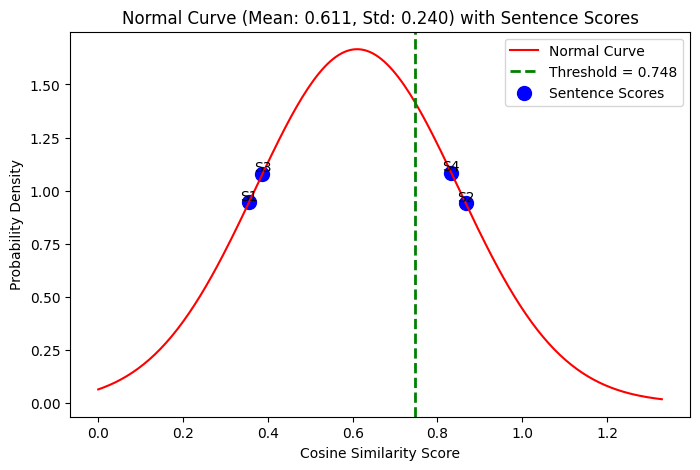

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Given candidate cosine similarity scores and the dynamic threshold
scores = np.array([0.3558751, 0.8665799, 0.3873144, 0.8323955])
threshold = 0.7480412125587463  # Dynamic threshold value

# Calculate mean and standard deviation of the scores
mean_score = np.mean(scores)
std_score = np.std(scores)

# Define x-axis range: from max(0, mean - 3*std) to mean + 3*std (ensuring positive values)
x = np.linspace(max(0, mean_score - 3 * std_score), mean_score + 3 * std_score, 200)
y = norm.pdf(x, loc=mean_score, scale=std_score)

# Plot the normal curve
plt.figure(figsize=(8, 5))
plt.plot(x, y, 'r-', label='Normal Curve')

# Draw a vertical line at the threshold value
plt.axvline(threshold, color='green', linestyle='--', linewidth=2, label=f'Threshold = {threshold:.3f}')

# Compute y-values for each candidate sentence based on the fitted normal curve
y_points = norm.pdf(scores, loc=mean_score, scale=std_score)

# Plot candidate sentence scores as blue dots
plt.scatter(scores, y_points, color='blue', s=100, label='Sentence Scores')

# Label each point with a sentence identifier
for i, score in enumerate(scores):
    plt.text(score, y_points[i] + 0.01, f"S{i+1}", horizontalalignment='center', fontsize=10)

plt.xlabel('Cosine Similarity Score')
plt.ylabel('Probability Density')
plt.title(f'Normal Curve (Mean: {mean_score:.3f}, Std: {std_score:.3f}) with Sentence Scores')
plt.legend()
plt.show()
